In [ ]:
!unzip -d  train_data/  data/data94938/eyedata.zip

In [1]:
import paddle
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from paddle.vision import transforms
from paddle.io import Dataset,DataLoader
from paddle.vision.models import resnet50, resnet101
import paddle.nn as nn 
from tqdm import tqdm
import random
import cv2 as cv
from sklearn.model_selection import train_test_split

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/__init__.py:107: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableMapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/rcsetup.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable, Mapping
/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/matplotlib/colors.py:53: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sized


In [2]:
base_path = 'train_data/eyetrain/Train/'
label = pd.read_excel(base_path + 'Fovea_Location_train.xlsx')
label['imgName'] = 'train_data/eyetrain/Train/fundus_image/' + label['imgName']
label = np.array(label)

In [ ]:
HW = []
for path in label['imgName']:
    img = np.array(Image.open(path))
    print(img.shape)
    
plt.title('HW_distribution')
plt.xlabel('H')
plt.ylabel('W')
plt.plot(img[:][0], img[:][1])
plt.show()


In [ ]:
'''

def Train_resize(img, size, xy):
    '''
    args:
        img:   PIL
        size:  缩放到标准的尺寸
        xy：   原尺寸的黄斑中心点
    return：
        img：  缩放后的尺寸
        xy：   调整后的坐标
    '''
    h, w = img.size[0], img.size[1]
    if h >= w:
        img = transforms.Resize(size=(size, int(w*size/h)))(img)
        img = transforms.ToTensor()(img)
        img_copy = paddle.to_tensor(np.zeros(shape=(3, size, size))).astype('float32')
        img_copy[:,:size, :int(w*size/h)] = img.astype('float32')
        # img_copy = transforms.ToPILImage()(img_copy)
#         img = np.resize(img, new_shape=(size, int(w*size/h), 3))
#         img = np.hstack([img, np.zeros(shape=(224, 224-int(w*size/h), 3), dtype=np.uint8)])
        xy[0] = xy[0] * size / h
        xy[1] = xy[1] * size / h
    else:
        img = transforms.Resize(size=(int(h*size/w), size))(img)
        img = transforms.ToTensor()(img)
        img_copy = paddle.to_tensor(np.zeros(shape=(3, size, size))).astype('float32')
        img_copy[:, :int(h*size/w), :size] = img.astype('float32')
#         img = np.resize(img, new_shape=(int(h*size/w), size, 3))
#         img = np.vstack([img, np.zeros(shape=(224-int(h*size/w), 224, 3), dtype=np.uint8)])
        xy[0] = xy[0] * size / w
        xy[1] = xy[1] * size / w
    return img_copy, xy
'''
    

In [3]:
# 对图片按照比例进行缩放（直接resize的话会导致定位不准）
def Train_size(img, size, xy):
    h, w, c = img.shape
    res = np.zeros(shape=(size, size, c), dtype='uint8')
    rate = 0 #缩放比例
    if h >= w:
        rate = size/h
        imgp = cv.resize(img, (int(w/h*size), size))
        res[:size, :int(w/h*size), :] = imgp 
    else:
        rate = size/w
        imgp = cv.resize(img, (size, int(h/w*size)))
        res[:int(h/w*size), :size] = imgp

    res = Image.fromarray(np.uint8(res))
    return res, xy*rate, rate  # 输出缩放后的图片，缩放后的坐标，缩放的比例

In [4]:
(label[0][2], label[0][1])

(790.54, 743.96)

In [5]:
mytransforms = [
    transforms.Compose([
        transforms.ColorJitter(0.2, 0.2, 0.2),
        transforms.ToTensor(),
    ]),
    transforms.Compose([
        transforms.ToTensor(),
    ]),
]
class Edataset(Dataset):
    def __init__(self, data, mytransforms, mode='train'):
        self.size = data.shape[0]
        self.transforms = mytransforms
        self.mode = mode
        self.data = data
        
    def __getitem__(self, index):
        img = np.array(Image.open(self.data[index % self.size][0]))
        xy = np.array([self.data[index % self.size][2], self.data[index % self.size][1]], dtype='float32')
        img, xy, rate = Train_size(img=img, size=448, xy=xy)
        if self.mode == 'train':
            return self.transforms[0](img), paddle.to_tensor(xy)
        else:
            return self.transforms[1](img), paddle.to_tensor(xy)
    
    def __len__(self):
        return self.size

In [6]:
dataset = Edataset(data=label, mytransforms=mytransforms)
dataset[0]

(Tensor(shape=[3, 448, 448], dtype=float32, place=CPUPlace, stop_gradient=True,
        [[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]]]),
 Tensor(shape=[2], dtype=float32, place=CPUPlace, stop_gradient=True,
        [245.26448059, 230.81307983]))

In [6]:
train_data, test_data = train_test_split(label, test_size=80)

In [7]:
class MyNet(nn.Layer):
    def __init__(self):
        super(MyNet, self).__init__()
        self.cnn = resnet50(pretrained=True)
        self.fc1 = nn.Linear(in_features=1000, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=2)
        self.leakyr = nn.LeakyReLU(0.2)
        # self.fc3 = nn.Linear(in_features=128, out_features=2)
        # self.classifiler = nn.Linear(in_features=128, out_features=1)
    def forward(self, x):
        output = self.cnn(x)
        output = self.fc1(output)
        output =self.leakyr(output)
        output = self.fc2(output)
        # output = nn.functional.relu(output)
        # output = self.fc2(output)
        # output = nn.functional.relu(output)
        # output = self.fc3(output)
        return output
        

In [8]:
net = MyNet()

W1103 17:04:58.914448   183 device_context.cc:404] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 10.1, Runtime API Version: 10.1
W1103 17:04:58.920148   183 device_context.cc:422] device: 0, cuDNN Version: 7.6.
100%|██████████| 151272/151272 [00:02<00:00, 55610.54it/s]


In [111]:
# train_dataset = Edataset(data=train_data, mode='train', mytransforms=mytransforms)
# test_dataset = Edataset(data=test_data, mode='train', mytransforms=mytransforms)
# # edataloader = DataLoader(dataset=edataset, batch_size=32)
# model = paddle.Model(net)

In [9]:
# 设置为GPU
paddle.set_device('gpu')

CUDAPlace(0)

In [10]:
train_loss = []
epoch = 40
lr = 0.001
lr = paddle.optimizer.lr.CosineAnnealingDecay(0.001, T_max=(epoch // 10))
opt = paddle.optimizer.Adam(parameters=net.parameters(), learning_rate=lr)
cretrion1 = paddle.nn.MSELoss()
# cretrion2 = paddle.nn.BCELoss()

In [11]:
edataset = Edataset(data=label, mytransforms=mytransforms, mode='train')
edataloader = DataLoader(dataset=edataset, batch_size=32, shuffle=True)

In [13]:
#有些功能还不会用，所以很惭愧，一般是放模型训练一定的批次，看看对应的结果，然后再一步步训练
#（之前采用的交叉验证然后感觉不太行，然后果断直接采用人工调，挺浪费时间的，从接触paddle框架
#到完成这个小的demo，只有短短的一个星期，作为深度小白还有很长的路要走）
for step in range(epoch):
    edataloader = tqdm(edataloader)
    for index, img_target in enumerate(edataloader):
        opt.clear_grad()
        img, xy = img_target
        res = net(img)
        loss = ((cretrion1(res[:, 0], xy[:, 0]) + cretrion1(res[:, 1], xy[:, 1]))  )
        print(f'[{step}/{epoch}], [train_loss:{loss.item()}]')
        train_loss.append(loss.item())
        loss.backward()
        opt.step()
    paddle.save(net.state_dict(), 'logs/' + str(step) + '.pdparams')


  4%|▍         | 1/25 [00:03<01:14,  3.08s/it]

[0/40], [train_loss:1136.656982421875]


  8%|▊         | 2/25 [00:05<01:09,  3.03s/it]

[0/40], [train_loss:2262.709716796875]


 12%|█▏        | 3/25 [00:09<01:08,  3.14s/it]

[0/40], [train_loss:1487.838134765625]


 16%|█▌        | 4/25 [00:13<01:09,  3.30s/it]

[0/40], [train_loss:683.3455810546875]


 20%|██        | 5/25 [00:16<01:04,  3.22s/it]

[0/40], [train_loss:8211.3642578125]


 24%|██▍       | 6/25 [00:18<00:58,  3.08s/it]

[0/40], [train_loss:2753.057861328125]


 28%|██▊       | 7/25 [00:21<00:54,  3.01s/it]

[0/40], [train_loss:2021.9124755859375]
[0/40], [train_loss:1203.2108154296875]


 36%|███▌      | 9/25 [00:27<00:47,  2.95s/it]

[0/40], [train_loss:6715.8134765625]
[0/40], [train_loss:8351.0712890625]


 44%|████▍     | 11/25 [00:33<00:39,  2.83s/it]

[0/40], [train_loss:4319.3486328125]


 48%|████▊     | 12/25 [00:35<00:36,  2.82s/it]

[0/40], [train_loss:1562.9019775390625]


 52%|█████▏    | 13/25 [00:38<00:34,  2.89s/it]

[0/40], [train_loss:1087.9554443359375]


 56%|█████▌    | 14/25 [00:41<00:31,  2.90s/it]

[0/40], [train_loss:1656.7510986328125]


 60%|██████    | 15/25 [00:45<00:29,  2.99s/it]

[0/40], [train_loss:2011.2626953125]
[0/40], [train_loss:7535.15478515625]


 68%|██████▊   | 17/25 [00:52<00:26,  3.25s/it]

[0/40], [train_loss:7416.064453125]


 72%|███████▏  | 18/25 [00:55<00:21,  3.12s/it]

[0/40], [train_loss:2126.76025390625]


 76%|███████▌  | 19/25 [00:58<00:18,  3.07s/it]

[0/40], [train_loss:1342.28759765625]


 80%|████████  | 20/25 [01:01<00:15,  3.18s/it]

[0/40], [train_loss:2058.959716796875]


 84%|████████▍ | 21/25 [01:04<00:12,  3.19s/it]

[0/40], [train_loss:2045.6146240234375]


 88%|████████▊ | 22/25 [01:07<00:09,  3.16s/it]

[0/40], [train_loss:908.3015747070312]


 92%|█████████▏| 23/25 [01:10<00:06,  3.03s/it]

[0/40], [train_loss:834.235595703125]
[0/40], [train_loss:1575.017822265625]


100%|██████████| 25/25 [01:16<00:00,  3.06s/it]

[0/40], [train_loss:4400.8984375]



  4%|▍         | 1/25 [00:02<01:02,  2.59s/it]

[1/40], [train_loss:1710.569091796875]


  8%|▊         | 2/25 [00:05<01:01,  2.66s/it]

[1/40], [train_loss:894.588134765625]


 12%|█▏        | 3/25 [00:08<00:59,  2.71s/it]

[1/40], [train_loss:6878.52294921875]


 16%|█▌        | 4/25 [00:10<00:56,  2.71s/it]

[1/40], [train_loss:2691.91748046875]


 20%|██        | 5/25 [00:13<00:55,  2.75s/it]

[1/40], [train_loss:1165.47607421875]


 24%|██▍       | 6/25 [00:16<00:53,  2.81s/it]

[1/40], [train_loss:1724.354248046875]
[1/40], [train_loss:7237.3388671875]


 28%|██▊       | 7/25 [00:19<00:51,  2.85s/it]

[1/40], [train_loss:603.2437744140625]


 36%|███▌      | 9/25 [00:25<00:45,  2.87s/it]

[1/40], [train_loss:1805.060302734375]


 40%|████      | 10/25 [00:28<00:44,  2.94s/it]

[1/40], [train_loss:513.0152587890625]


 44%|████▍     | 11/25 [00:31<00:41,  2.94s/it]

[1/40], [train_loss:776.3865966796875]


 48%|████▊     | 12/25 [00:34<00:38,  2.96s/it]

[1/40], [train_loss:812.8097534179688]


 52%|█████▏    | 13/25 [00:37<00:36,  3.04s/it]

[1/40], [train_loss:497.4613037109375]


 56%|█████▌    | 14/25 [00:40<00:33,  3.01s/it]

[1/40], [train_loss:5999.623046875]
[1/40], [train_loss:674.0020751953125]


 64%|██████▍   | 16/25 [00:46<00:26,  2.97s/it]

[1/40], [train_loss:1700.6328125]
[1/40], [train_loss:6012.37353515625]


 72%|███████▏  | 18/25 [00:52<00:20,  2.92s/it]

[1/40], [train_loss:1465.39990234375]


 76%|███████▌  | 19/25 [00:55<00:17,  2.94s/it]

[1/40], [train_loss:659.2703857421875]


 80%|████████  | 20/25 [00:58<00:14,  2.95s/it]

[1/40], [train_loss:5066.3056640625]


 84%|████████▍ | 21/25 [01:01<00:11,  2.96s/it]

[1/40], [train_loss:895.6068115234375]


 88%|████████▊ | 22/25 [01:04<00:08,  2.88s/it]

[1/40], [train_loss:3586.088134765625]


 92%|█████████▏| 23/25 [01:06<00:05,  2.86s/it]

[1/40], [train_loss:1850.34130859375]


 96%|█████████▌| 24/25 [01:09<00:02,  2.82s/it]

[1/40], [train_loss:8408.271484375]


100%|██████████| 25/25 [01:12<00:00,  2.90s/it]

[1/40], [train_loss:644.9203491210938]



  4%|▍         | 1/25 [00:02<01:10,  2.94s/it]

[2/40], [train_loss:1161.307373046875]


  8%|▊         | 2/25 [00:05<01:07,  2.92s/it]

[2/40], [train_loss:6241.576171875]
[2/40], [train_loss:1053.034423828125]


 12%|█▏        | 3/25 [00:08<01:05,  2.98s/it]

[2/40], [train_loss:2161.869384765625]


 16%|█▌        | 4/25 [00:11<01:01,  2.93s/it]

[2/40], [train_loss:1020.2379760742188]


 24%|██▍       | 6/25 [00:17<00:53,  2.83s/it]

[2/40], [train_loss:1754.329833984375]


 28%|██▊       | 7/25 [00:20<00:50,  2.82s/it]

[2/40], [train_loss:10132.154296875]


 32%|███▏      | 8/25 [00:22<00:47,  2.80s/it]

[2/40], [train_loss:1242.731689453125]
[2/40], [train_loss:1449.73828125]


 40%|████      | 10/25 [00:28<00:42,  2.86s/it]

[2/40], [train_loss:2170.04931640625]


 44%|████▍     | 11/25 [00:31<00:40,  2.89s/it]

[2/40], [train_loss:5154.8330078125]


 48%|████▊     | 12/25 [00:34<00:37,  2.88s/it]

[2/40], [train_loss:1325.4295654296875]


 52%|█████▏    | 13/25 [00:37<00:34,  2.86s/it]

[2/40], [train_loss:1915.605712890625]


 56%|█████▌    | 14/25 [00:40<00:31,  2.87s/it]

[2/40], [train_loss:1159.8004150390625]


 60%|██████    | 15/25 [00:42<00:28,  2.81s/it]

[2/40], [train_loss:1165.0526123046875]


 64%|██████▍   | 16/25 [00:45<00:25,  2.82s/it]

[2/40], [train_loss:1480.23046875]


 68%|██████▊   | 17/25 [00:48<00:23,  2.88s/it]

[2/40], [train_loss:8554.8525390625]


 72%|███████▏  | 18/25 [00:51<00:20,  2.87s/it]

[2/40], [train_loss:1287.072998046875]
[2/40], [train_loss:1728.681640625]


 80%|████████  | 20/25 [00:57<00:14,  2.87s/it]

[2/40], [train_loss:4606.05810546875]


 84%|████████▍ | 21/25 [01:00<00:11,  2.97s/it]

[2/40], [train_loss:1006.849853515625]


 88%|████████▊ | 22/25 [01:03<00:08,  2.84s/it]

[2/40], [train_loss:2551.377197265625]


 92%|█████████▏| 23/25 [01:06<00:05,  2.90s/it]

[2/40], [train_loss:781.1981201171875]


 96%|█████████▌| 24/25 [01:09<00:02,  2.90s/it]

[2/40], [train_loss:529.2056274414062]


100%|██████████| 25/25 [01:12<00:00,  2.88s/it]

[2/40], [train_loss:1708.094970703125]



  0%|          | 0/25 [00:00<?, ?it/s]

[3/40], [train_loss:1103.404296875]


  4%|▍         | 1/25 [00:03<01:14,  3.08s/it]

[3/40], [train_loss:4206.19091796875]


 12%|█▏        | 3/25 [00:08<01:05,  2.96s/it]

[3/40], [train_loss:1844.885986328125]


 16%|█▌        | 4/25 [00:11<01:01,  2.94s/it]

[3/40], [train_loss:1063.5821533203125]


 20%|██        | 5/25 [00:14<00:58,  2.91s/it]

[3/40], [train_loss:2051.6328125]


 24%|██▍       | 6/25 [00:17<00:54,  2.89s/it]

[3/40], [train_loss:651.329833984375]


 28%|██▊       | 7/25 [00:20<00:52,  2.89s/it]

[3/40], [train_loss:4451.4248046875]


 32%|███▏      | 8/25 [00:23<00:49,  2.93s/it]

[3/40], [train_loss:1360.76416015625]


 36%|███▌      | 9/25 [00:26<00:46,  2.92s/it]

[3/40], [train_loss:556.7570190429688]


 40%|████      | 10/25 [00:29<00:44,  2.95s/it]

[3/40], [train_loss:393.9977722167969]


 44%|████▍     | 11/25 [00:32<00:41,  2.96s/it]

[3/40], [train_loss:1716.3525390625]


 48%|████▊     | 12/25 [00:35<00:38,  2.94s/it]

[3/40], [train_loss:878.2413940429688]
[3/40], [train_loss:541.542236328125]


 52%|█████▏    | 13/25 [00:38<00:35,  3.00s/it]

[3/40], [train_loss:1012.0784301757812]


 56%|█████▌    | 14/25 [00:41<00:32,  2.95s/it]

[3/40], [train_loss:1017.06982421875]


 64%|██████▍   | 16/25 [00:46<00:25,  2.86s/it]

[3/40], [train_loss:6884.734375]


 68%|██████▊   | 17/25 [00:49<00:22,  2.83s/it]

[3/40], [train_loss:805.1871337890625]


 72%|███████▏  | 18/25 [00:52<00:20,  2.89s/it]

[3/40], [train_loss:7390.81103515625]


 76%|███████▌  | 19/25 [00:55<00:17,  2.89s/it]

[3/40], [train_loss:6391.0205078125]


 80%|████████  | 20/25 [00:58<00:14,  2.90s/it]

[3/40], [train_loss:1044.794921875]


 84%|████████▍ | 21/25 [01:01<00:11,  2.87s/it]

[3/40], [train_loss:2945.580078125]
[3/40], [train_loss:5441.6142578125]


 88%|████████▊ | 22/25 [01:04<00:08,  2.94s/it]

[3/40], [train_loss:2020.466796875]


 96%|█████████▌| 24/25 [01:09<00:02,  2.88s/it]

[3/40], [train_loss:1603.7650146484375]


100%|██████████| 25/25 [01:12<00:00,  2.91s/it]

[3/40], [train_loss:1864.291748046875]



  4%|▍         | 1/25 [00:02<01:05,  2.72s/it]

[4/40], [train_loss:4986.419921875]


  8%|▊         | 2/25 [00:05<01:03,  2.78s/it]

[4/40], [train_loss:1494.968505859375]


 12%|█▏        | 3/25 [00:08<01:03,  2.86s/it]

[4/40], [train_loss:1917.4365234375]


 16%|█▌        | 4/25 [00:11<01:00,  2.89s/it]

[4/40], [train_loss:1020.291015625]


 20%|██        | 5/25 [00:14<00:58,  2.91s/it]

[4/40], [train_loss:815.756103515625]


 24%|██▍       | 6/25 [00:17<00:54,  2.86s/it]

[4/40], [train_loss:3988.6982421875]


 28%|██▊       | 7/25 [00:20<00:51,  2.85s/it]

[4/40], [train_loss:7107.25390625]


 32%|███▏      | 8/25 [00:23<00:49,  2.91s/it]

[4/40], [train_loss:697.216064453125]


 36%|███▌      | 9/25 [00:26<00:46,  2.91s/it]

[4/40], [train_loss:623.08251953125]


 40%|████      | 10/25 [00:28<00:43,  2.88s/it]

[4/40], [train_loss:1526.081298828125]


 44%|████▍     | 11/25 [00:31<00:40,  2.86s/it]

[4/40], [train_loss:1398.817626953125]
[4/40], [train_loss:2665.9853515625]


 48%|████▊     | 12/25 [00:34<00:38,  2.96s/it]

[4/40], [train_loss:1300.8853759765625]


 56%|█████▌    | 14/25 [00:40<00:31,  2.87s/it]

[4/40], [train_loss:782.091796875]


 60%|██████    | 15/25 [00:43<00:28,  2.86s/it]

[4/40], [train_loss:1511.1932373046875]


 64%|██████▍   | 16/25 [00:46<00:25,  2.88s/it]

[4/40], [train_loss:933.431884765625]
[4/40], [train_loss:656.067138671875]


 72%|███████▏  | 18/25 [00:52<00:19,  2.85s/it]

[4/40], [train_loss:1685.119873046875]
[4/40], [train_loss:607.3314208984375]


 80%|████████  | 20/25 [00:57<00:14,  2.81s/it]

[4/40], [train_loss:653.1685791015625]


 84%|████████▍ | 21/25 [01:00<00:11,  2.86s/it]

[4/40], [train_loss:4716.16943359375]


 88%|████████▊ | 22/25 [01:03<00:08,  2.83s/it]

[4/40], [train_loss:6653.88330078125]


 92%|█████████▏| 23/25 [01:06<00:05,  2.86s/it]

[4/40], [train_loss:4641.26708984375]


 96%|█████████▌| 24/25 [01:09<00:02,  2.83s/it]

[4/40], [train_loss:2185.68701171875]


100%|██████████| 25/25 [01:11<00:00,  2.88s/it]

[4/40], [train_loss:5524.97265625]



  0%|          | 0/25 [00:00<?, ?it/s]

[5/40], [train_loss:5485.9306640625]


  4%|▍         | 1/25 [00:03<01:12,  3.00s/it]

[5/40], [train_loss:4952.41064453125]


  8%|▊         | 2/25 [00:05<01:07,  2.95s/it]

[5/40], [train_loss:2786.36376953125]


 16%|█▌        | 4/25 [00:11<00:59,  2.85s/it]

[5/40], [train_loss:1727.306884765625]


 20%|██        | 5/25 [00:14<00:58,  2.91s/it]

[5/40], [train_loss:501.201904296875]


 24%|██▍       | 6/25 [00:17<00:55,  2.90s/it]

[5/40], [train_loss:3837.38037109375]


 28%|██▊       | 7/25 [00:20<00:52,  2.91s/it]

[5/40], [train_loss:1126.8236083984375]


 32%|███▏      | 8/25 [00:23<00:48,  2.88s/it]

[5/40], [train_loss:1090.625244140625]


 36%|███▌      | 9/25 [00:25<00:46,  2.88s/it]

[5/40], [train_loss:904.3274536132812]


 40%|████      | 10/25 [00:28<00:43,  2.90s/it]

[5/40], [train_loss:7603.3916015625]
[5/40], [train_loss:5698.6796875]


 48%|████▊     | 12/25 [00:34<00:37,  2.92s/it]

[5/40], [train_loss:1790.96875]


 52%|█████▏    | 13/25 [00:37<00:35,  2.97s/it]

[5/40], [train_loss:1998.2452392578125]


 56%|█████▌    | 14/25 [00:40<00:32,  2.99s/it]

[5/40], [train_loss:904.98779296875]


 60%|██████    | 15/25 [00:43<00:30,  3.01s/it]

[5/40], [train_loss:2252.9052734375]


 64%|██████▍   | 16/25 [00:46<00:26,  2.99s/it]

[5/40], [train_loss:1630.55615234375]


 68%|██████▊   | 17/25 [00:50<00:24,  3.06s/it]

[5/40], [train_loss:4508.08203125]


 72%|███████▏  | 18/25 [00:53<00:21,  3.14s/it]

[5/40], [train_loss:1302.9468994140625]


 76%|███████▌  | 19/25 [00:56<00:18,  3.11s/it]

[5/40], [train_loss:792.2353515625]


 80%|████████  | 20/25 [00:59<00:15,  3.09s/it]

[5/40], [train_loss:549.0899658203125]


 84%|████████▍ | 21/25 [01:02<00:12,  3.09s/it]

[5/40], [train_loss:1008.439208984375]


 88%|████████▊ | 22/25 [01:05<00:09,  3.05s/it]

[5/40], [train_loss:737.083251953125]


 92%|█████████▏| 23/25 [01:08<00:06,  3.05s/it]

[5/40], [train_loss:1338.9091796875]


 96%|█████████▌| 24/25 [01:11<00:03,  3.03s/it]

[5/40], [train_loss:530.90087890625]


100%|██████████| 25/25 [01:14<00:00,  2.98s/it]

[5/40], [train_loss:811.3218383789062]



  0%|          | 0/25 [00:00<?, ?it/s]

[6/40], [train_loss:422.6244812011719]


  8%|▊         | 2/25 [00:05<01:06,  2.89s/it]

[6/40], [train_loss:7417.8095703125]


 12%|█▏        | 3/25 [00:08<01:03,  2.87s/it]

[6/40], [train_loss:1115.59521484375]
[6/40], [train_loss:546.9388427734375]


 20%|██        | 5/25 [00:14<00:57,  2.87s/it]

[6/40], [train_loss:873.073486328125]


 24%|██▍       | 6/25 [00:17<00:54,  2.87s/it]

[6/40], [train_loss:5612.00634765625]


 28%|██▊       | 7/25 [00:19<00:51,  2.89s/it]

[6/40], [train_loss:660.9957275390625]


 32%|███▏      | 8/25 [00:22<00:49,  2.89s/it]

[6/40], [train_loss:5264.2744140625]


 36%|███▌      | 9/25 [00:25<00:45,  2.87s/it]

[6/40], [train_loss:5453.4560546875]
[6/40], [train_loss:2113.64794921875]


 44%|████▍     | 11/25 [00:32<00:41,  3.00s/it]

[6/40], [train_loss:870.4732666015625]


 48%|████▊     | 12/25 [00:34<00:38,  2.97s/it]

[6/40], [train_loss:5672.29052734375]


 52%|█████▏    | 13/25 [00:37<00:35,  2.95s/it]

[6/40], [train_loss:1226.4305419921875]


 56%|█████▌    | 14/25 [00:40<00:32,  2.97s/it]

[6/40], [train_loss:1671.49365234375]


 60%|██████    | 15/25 [00:43<00:29,  2.97s/it]

[6/40], [train_loss:711.126220703125]


 64%|██████▍   | 16/25 [00:46<00:26,  3.00s/it]

[6/40], [train_loss:1237.681640625]


 68%|██████▊   | 17/25 [00:49<00:23,  2.98s/it]

[6/40], [train_loss:1005.821533203125]


 72%|███████▏  | 18/25 [00:52<00:20,  2.92s/it]

[6/40], [train_loss:1219.920166015625]
[6/40], [train_loss:917.2084350585938]


 80%|████████  | 20/25 [00:58<00:14,  2.88s/it]

[6/40], [train_loss:912.055908203125]


 84%|████████▍ | 21/25 [01:01<00:11,  2.90s/it]

[6/40], [train_loss:717.507080078125]


 88%|████████▊ | 22/25 [01:04<00:08,  2.90s/it]

[6/40], [train_loss:991.8863525390625]


 92%|█████████▏| 23/25 [01:07<00:05,  2.97s/it]

[6/40], [train_loss:1297.1026611328125]


 96%|█████████▌| 24/25 [01:10<00:02,  2.96s/it]

[6/40], [train_loss:4020.765625]


100%|██████████| 25/25 [01:13<00:00,  2.93s/it]

[6/40], [train_loss:1357.5982666015625]



  4%|▍         | 1/25 [00:02<01:06,  2.77s/it]

[7/40], [train_loss:2759.1650390625]


  8%|▊         | 2/25 [00:05<01:05,  2.84s/it]

[7/40], [train_loss:1106.312255859375]


 12%|█▏        | 3/25 [00:08<01:02,  2.84s/it]

[7/40], [train_loss:4968.7392578125]


 16%|█▌        | 4/25 [00:11<00:59,  2.83s/it]

[7/40], [train_loss:873.6143798828125]


 20%|██        | 5/25 [00:14<00:57,  2.87s/it]

[7/40], [train_loss:2584.18212890625]


 24%|██▍       | 6/25 [00:17<00:54,  2.89s/it]

[7/40], [train_loss:1122.8646240234375]


 28%|██▊       | 7/25 [00:20<00:52,  2.90s/it]

[7/40], [train_loss:694.9802856445312]


 32%|███▏      | 8/25 [00:23<00:49,  2.92s/it]

[7/40], [train_loss:1182.8876953125]


 36%|███▌      | 9/25 [00:26<00:46,  2.90s/it]

[7/40], [train_loss:1063.677001953125]


 40%|████      | 10/25 [00:29<00:44,  2.97s/it]

[7/40], [train_loss:454.79705810546875]


 44%|████▍     | 11/25 [00:32<00:42,  3.03s/it]

[7/40], [train_loss:1299.0634765625]


 48%|████▊     | 12/25 [00:35<00:39,  3.02s/it]

[7/40], [train_loss:734.6171875]


 52%|█████▏    | 13/25 [00:38<00:35,  2.93s/it]

[7/40], [train_loss:955.1458129882812]
[7/40], [train_loss:1198.5185546875]


 56%|█████▌    | 14/25 [00:41<00:32,  2.97s/it]

[7/40], [train_loss:1055.1917724609375]


 64%|██████▍   | 16/25 [00:46<00:26,  2.94s/it]

[7/40], [train_loss:4096.7060546875]
[7/40], [train_loss:1957.3507080078125]


 72%|███████▏  | 18/25 [00:53<00:21,  3.04s/it]

[7/40], [train_loss:2119.929443359375]
[7/40], [train_loss:1309.55224609375]


 76%|███████▌  | 19/25 [00:56<00:18,  3.08s/it]

[7/40], [train_loss:2116.2529296875]


 84%|████████▍ | 21/25 [01:01<00:11,  2.87s/it]

[7/40], [train_loss:9321.9619140625]


 88%|████████▊ | 22/25 [01:04<00:08,  2.88s/it]

[7/40], [train_loss:2344.861572265625]


 92%|█████████▏| 23/25 [01:07<00:05,  2.85s/it]

[7/40], [train_loss:6545.55615234375]


 96%|█████████▌| 24/25 [01:10<00:02,  2.82s/it]

[7/40], [train_loss:5674.3984375]


100%|██████████| 25/25 [01:13<00:00,  2.93s/it]

[7/40], [train_loss:1168.6151123046875]



  0%|          | 0/25 [00:00<?, ?it/s]

[8/40], [train_loss:1309.84521484375]


  4%|▍         | 1/25 [00:03<01:15,  3.16s/it]

[8/40], [train_loss:1442.1513671875]


 12%|█▏        | 3/25 [00:08<01:05,  2.96s/it]

[8/40], [train_loss:1757.2698974609375]
[8/40], [train_loss:1502.2366943359375]


 20%|██        | 5/25 [00:14<00:58,  2.93s/it]

[8/40], [train_loss:1629.953857421875]


 24%|██▍       | 6/25 [00:17<00:54,  2.85s/it]

[8/40], [train_loss:6185.4833984375]


 28%|██▊       | 7/25 [00:20<00:50,  2.82s/it]

[8/40], [train_loss:1074.177734375]


 32%|███▏      | 8/25 [00:22<00:48,  2.84s/it]

[8/40], [train_loss:4873.56982421875]


 36%|███▌      | 9/25 [00:25<00:46,  2.88s/it]

[8/40], [train_loss:1162.7677001953125]


 40%|████      | 10/25 [00:28<00:43,  2.92s/it]

[8/40], [train_loss:1559.93017578125]


 44%|████▍     | 11/25 [00:31<00:40,  2.92s/it]

[8/40], [train_loss:1571.57763671875]


 48%|████▊     | 12/25 [00:34<00:37,  2.87s/it]

[8/40], [train_loss:1709.346923828125]
[8/40], [train_loss:3875.239013671875]


 56%|█████▌    | 14/25 [00:40<00:31,  2.89s/it]

[8/40], [train_loss:1880.91455078125]


 60%|██████    | 15/25 [00:43<00:29,  2.92s/it]

[8/40], [train_loss:1475.1025390625]
[8/40], [train_loss:838.9365234375]


 64%|██████▍   | 16/25 [00:46<00:26,  2.97s/it]

[8/40], [train_loss:5419.27587890625]


 72%|███████▏  | 18/25 [00:52<00:19,  2.85s/it]

[8/40], [train_loss:4762.23681640625]


 76%|███████▌  | 19/25 [00:55<00:17,  2.87s/it]

[8/40], [train_loss:3302.01220703125]


 80%|████████  | 20/25 [00:57<00:14,  2.85s/it]

[8/40], [train_loss:3047.52587890625]


 84%|████████▍ | 21/25 [01:00<00:11,  2.86s/it]

[8/40], [train_loss:795.6807861328125]


 88%|████████▊ | 22/25 [01:03<00:08,  2.88s/it]

[8/40], [train_loss:1145.6494140625]


 92%|█████████▏| 23/25 [01:06<00:05,  2.93s/it]

[8/40], [train_loss:1222.4227294921875]


 96%|█████████▌| 24/25 [01:09<00:02,  2.86s/it]

[8/40], [train_loss:1166.6854248046875]


100%|██████████| 25/25 [01:12<00:00,  2.89s/it]

[8/40], [train_loss:1025.481201171875]



  4%|▍         | 1/25 [00:02<01:07,  2.82s/it]

[9/40], [train_loss:701.416015625]


  8%|▊         | 2/25 [00:05<01:04,  2.79s/it]

[9/40], [train_loss:1613.55615234375]


 12%|█▏        | 3/25 [00:08<01:02,  2.86s/it]

[9/40], [train_loss:756.5153198242188]
[9/40], [train_loss:598.51318359375]


 16%|█▌        | 4/25 [00:11<01:02,  2.96s/it]

[9/40], [train_loss:4545.31103515625]


 24%|██▍       | 6/25 [00:17<00:55,  2.92s/it]

[9/40], [train_loss:570.0044555664062]


 28%|██▊       | 7/25 [00:20<00:53,  2.96s/it]

[9/40], [train_loss:3414.08642578125]


 32%|███▏      | 8/25 [00:23<00:50,  3.00s/it]

[9/40], [train_loss:403.359375]


 36%|███▌      | 9/25 [00:26<00:47,  2.96s/it]

[9/40], [train_loss:717.8633422851562]


 40%|████      | 10/25 [00:29<00:44,  2.94s/it]

[9/40], [train_loss:1228.1636962890625]


 44%|████▍     | 11/25 [00:32<00:41,  2.95s/it]

[9/40], [train_loss:411.61383056640625]


 48%|████▊     | 12/25 [00:35<00:37,  2.86s/it]

[9/40], [train_loss:653.9788208007812]
[9/40], [train_loss:655.5935668945312]


 52%|█████▏    | 13/25 [00:38<00:35,  2.96s/it]

[9/40], [train_loss:971.5421142578125]


 60%|██████    | 15/25 [00:43<00:28,  2.86s/it]

[9/40], [train_loss:4320.08642578125]


 64%|██████▍   | 16/25 [00:46<00:25,  2.87s/it]

[9/40], [train_loss:644.8683471679688]


 68%|██████▊   | 17/25 [00:49<00:23,  2.91s/it]

[9/40], [train_loss:669.0150756835938]


 72%|███████▏  | 18/25 [00:53<00:22,  3.15s/it]

[9/40], [train_loss:1255.48388671875]


 76%|███████▌  | 19/25 [00:56<00:18,  3.12s/it]

[9/40], [train_loss:1218.119384765625]


 80%|████████  | 20/25 [00:59<00:15,  3.05s/it]

[9/40], [train_loss:1295.9373779296875]


 84%|████████▍ | 21/25 [01:02<00:11,  2.99s/it]

[9/40], [train_loss:4755.5]


 88%|████████▊ | 22/25 [01:05<00:08,  2.94s/it]

[9/40], [train_loss:7333.02099609375]
[9/40], [train_loss:1094.74853515625]


 96%|█████████▌| 24/25 [01:11<00:02,  2.95s/it]

[9/40], [train_loss:836.7734985351562]


100%|██████████| 25/25 [01:13<00:00,  2.96s/it]

[9/40], [train_loss:900.4945068359375]



  0%|          | 0/25 [00:00<?, ?it/s]

[10/40], [train_loss:1847.393310546875]


  8%|▊         | 2/25 [00:05<01:07,  2.94s/it]

[10/40], [train_loss:689.8405151367188]
[10/40], [train_loss:3217.166748046875]


 16%|█▌        | 4/25 [00:11<01:00,  2.90s/it]

[10/40], [train_loss:594.6826171875]


 20%|██        | 5/25 [00:14<00:57,  2.85s/it]

[10/40], [train_loss:2563.20166015625]


 24%|██▍       | 6/25 [00:17<00:54,  2.84s/it]

[10/40], [train_loss:6434.15478515625]
[10/40], [train_loss:2996.771728515625]


 32%|███▏      | 8/25 [00:22<00:48,  2.84s/it]

[10/40], [train_loss:1740.6328125]


 36%|███▌      | 9/25 [00:27<00:55,  3.50s/it]

[10/40], [train_loss:733.7533569335938]


 40%|████      | 10/25 [00:31<00:51,  3.40s/it]

[10/40], [train_loss:853.5484619140625]


 44%|████▍     | 11/25 [00:34<00:45,  3.27s/it]

[10/40], [train_loss:1288.014892578125]


 48%|████▊     | 12/25 [00:36<00:40,  3.15s/it]

[10/40], [train_loss:1328.9844970703125]


 52%|█████▏    | 13/25 [00:39<00:36,  3.06s/it]

[10/40], [train_loss:1028.177978515625]


 56%|█████▌    | 14/25 [00:42<00:33,  3.00s/it]

[10/40], [train_loss:793.544189453125]


 60%|██████    | 15/25 [00:45<00:29,  2.97s/it]

[10/40], [train_loss:648.5914306640625]


 64%|██████▍   | 16/25 [00:48<00:26,  2.98s/it]

[10/40], [train_loss:5584.3564453125]


 68%|██████▊   | 17/25 [00:51<00:23,  2.98s/it]

[10/40], [train_loss:390.468505859375]


 72%|███████▏  | 18/25 [00:54<00:20,  2.96s/it]

[10/40], [train_loss:1229.917236328125]


 76%|███████▌  | 19/25 [00:57<00:17,  2.97s/it]

[10/40], [train_loss:1035.0018310546875]


 80%|████████  | 20/25 [01:00<00:14,  2.95s/it]

[10/40], [train_loss:3222.47021484375]


 84%|████████▍ | 21/25 [01:03<00:11,  2.93s/it]

[10/40], [train_loss:1270.5438232421875]
[10/40], [train_loss:639.206787109375]


 92%|█████████▏| 23/25 [01:08<00:05,  2.88s/it]

[10/40], [train_loss:1001.7594604492188]
[10/40], [train_loss:5660.11376953125]


100%|██████████| 25/25 [01:14<00:00,  2.99s/it]

[10/40], [train_loss:7290.6640625]



  4%|▍         | 1/25 [00:02<01:09,  2.92s/it]

[11/40], [train_loss:984.3151245117188]
[11/40], [train_loss:1143.9537353515625]


  8%|▊         | 2/25 [00:06<01:09,  3.00s/it]

[11/40], [train_loss:1635.612548828125]


 16%|█▌        | 4/25 [00:11<01:00,  2.86s/it]

[11/40], [train_loss:882.9127197265625]


 20%|██        | 5/25 [00:14<00:57,  2.85s/it]

[11/40], [train_loss:1645.268798828125]
[11/40], [train_loss:1027.97021484375]


 28%|██▊       | 7/25 [00:20<00:51,  2.84s/it]

[11/40], [train_loss:1148.663818359375]


 32%|███▏      | 8/25 [00:23<00:48,  2.87s/it]

[11/40], [train_loss:729.4728393554688]
[11/40], [train_loss:3158.8916015625]


 40%|████      | 10/25 [00:28<00:43,  2.87s/it]

[11/40], [train_loss:1323.4124755859375]


 44%|████▍     | 11/25 [00:31<00:39,  2.85s/it]

[11/40], [train_loss:3317.2490234375]


 48%|████▊     | 12/25 [00:34<00:36,  2.83s/it]

[11/40], [train_loss:1086.4912109375]
[11/40], [train_loss:3518.59423828125]


 52%|█████▏    | 13/25 [00:37<00:35,  2.93s/it]

[11/40], [train_loss:1458.631103515625]


 60%|██████    | 15/25 [00:43<00:28,  2.85s/it]

[11/40], [train_loss:1177.9664306640625]


 64%|██████▍   | 16/25 [00:46<00:26,  2.90s/it]

[11/40], [train_loss:2716.220458984375]


 68%|██████▊   | 17/25 [00:49<00:23,  2.91s/it]

[11/40], [train_loss:599.6614990234375]


 72%|███████▏  | 18/25 [00:51<00:20,  2.86s/it]

[11/40], [train_loss:1170.69287109375]


 76%|███████▌  | 19/25 [00:54<00:17,  2.90s/it]

[11/40], [train_loss:690.140869140625]


 80%|████████  | 20/25 [00:57<00:14,  2.88s/it]

[11/40], [train_loss:796.3651123046875]


 84%|████████▍ | 21/25 [01:00<00:11,  2.85s/it]

[11/40], [train_loss:852.11083984375]


 88%|████████▊ | 22/25 [01:03<00:08,  2.90s/it]

[11/40], [train_loss:627.7203979492188]


 92%|█████████▏| 23/25 [01:06<00:05,  2.97s/it]

[11/40], [train_loss:465.928955078125]


 96%|█████████▌| 24/25 [01:09<00:02,  2.92s/it]

[11/40], [train_loss:6126.615234375]


100%|██████████| 25/25 [01:12<00:00,  2.90s/it]

[11/40], [train_loss:596.0728759765625]



  0%|          | 0/25 [00:00<?, ?it/s]

[12/40], [train_loss:1556.8875732421875]


  8%|▊         | 2/25 [00:05<01:03,  2.76s/it]

[12/40], [train_loss:1766.326904296875]
[12/40], [train_loss:656.2950439453125]


 12%|█▏        | 3/25 [00:08<01:03,  2.89s/it]

[12/40], [train_loss:1834.1483154296875]


 20%|██        | 5/25 [00:14<00:56,  2.82s/it]

[12/40], [train_loss:4550.0537109375]


 24%|██▍       | 6/25 [00:17<00:54,  2.87s/it]

[12/40], [train_loss:673.0703735351562]


 28%|██▊       | 7/25 [00:19<00:51,  2.87s/it]

[12/40], [train_loss:1268.7864990234375]


 32%|███▏      | 8/25 [00:22<00:49,  2.90s/it]

[12/40], [train_loss:894.0933837890625]


 36%|███▌      | 9/25 [00:25<00:46,  2.88s/it]

[12/40], [train_loss:1620.4931640625]
[12/40], [train_loss:1411.88671875]


 44%|████▍     | 11/25 [00:31<00:40,  2.89s/it]

[12/40], [train_loss:662.8807373046875]
[12/40], [train_loss:3583.7392578125]


 48%|████▊     | 12/25 [00:34<00:38,  3.00s/it]

[12/40], [train_loss:1141.709716796875]


 52%|█████▏    | 13/25 [00:38<00:37,  3.11s/it]

[12/40], [train_loss:4532.4677734375]


 60%|██████    | 15/25 [00:43<00:29,  2.94s/it]

[12/40], [train_loss:4093.924072265625]


 64%|██████▍   | 16/25 [00:46<00:25,  2.86s/it]

[12/40], [train_loss:2578.361328125]


 68%|██████▊   | 17/25 [00:49<00:22,  2.87s/it]

[12/40], [train_loss:3897.86474609375]


 72%|███████▏  | 18/25 [00:52<00:19,  2.85s/it]

[12/40], [train_loss:1285.30078125]


 76%|███████▌  | 19/25 [00:55<00:17,  2.87s/it]

[12/40], [train_loss:864.928955078125]


 80%|████████  | 20/25 [00:58<00:14,  2.90s/it]

[12/40], [train_loss:1008.3482666015625]


 84%|████████▍ | 21/25 [01:00<00:11,  2.86s/it]

[12/40], [train_loss:779.5940551757812]
[12/40], [train_loss:1930.787353515625]


 92%|█████████▏| 23/25 [01:06<00:05,  2.92s/it]

[12/40], [train_loss:3372.85693359375]


 96%|█████████▌| 24/25 [01:09<00:02,  2.94s/it]

[12/40], [train_loss:983.3837890625]


100%|██████████| 25/25 [01:12<00:00,  2.91s/it]

[12/40], [train_loss:1539.4730224609375]



  4%|▍         | 1/25 [00:02<01:05,  2.71s/it]

[13/40], [train_loss:1514.109375]


  8%|▊         | 2/25 [00:05<01:03,  2.77s/it]

[13/40], [train_loss:4158.7421875]


 12%|█▏        | 3/25 [00:08<01:01,  2.80s/it]

[13/40], [train_loss:700.0091552734375]
[13/40], [train_loss:637.6968383789062]


 20%|██        | 5/25 [00:14<00:58,  2.92s/it]

[13/40], [train_loss:4764.6552734375]


 24%|██▍       | 6/25 [00:17<00:56,  2.96s/it]

[13/40], [train_loss:655.3594360351562]
[13/40], [train_loss:539.5664672851562]


 32%|███▏      | 8/25 [00:23<00:50,  2.98s/it]

[13/40], [train_loss:1460.86328125]


 36%|███▌      | 9/25 [00:26<00:47,  2.94s/it]

[13/40], [train_loss:556.562744140625]


 40%|████      | 10/25 [00:29<00:43,  2.90s/it]

[13/40], [train_loss:810.0716552734375]


 44%|████▍     | 11/25 [00:32<00:40,  2.92s/it]

[13/40], [train_loss:932.250244140625]
[13/40], [train_loss:5325.1376953125]


 52%|█████▏    | 13/25 [00:38<00:34,  2.89s/it]

[13/40], [train_loss:803.4645385742188]


 56%|█████▌    | 14/25 [00:41<00:31,  2.88s/it]

[13/40], [train_loss:1263.707275390625]


 60%|██████    | 15/25 [00:43<00:28,  2.89s/it]

[13/40], [train_loss:1355.354736328125]


 64%|██████▍   | 16/25 [00:46<00:26,  2.91s/it]

[13/40], [train_loss:4510.86328125]


 68%|██████▊   | 17/25 [00:49<00:23,  2.95s/it]

[13/40], [train_loss:589.4627685546875]


 72%|███████▏  | 18/25 [00:52<00:20,  2.93s/it]

[13/40], [train_loss:4918.59033203125]


 76%|███████▌  | 19/25 [00:55<00:17,  2.89s/it]

[13/40], [train_loss:1125.124755859375]


 80%|████████  | 20/25 [00:58<00:15,  3.03s/it]

[13/40], [train_loss:1333.735107421875]


 84%|████████▍ | 21/25 [01:01<00:11,  2.96s/it]

[13/40], [train_loss:1526.258056640625]


 88%|████████▊ | 22/25 [01:04<00:08,  2.96s/it]

[13/40], [train_loss:2166.2890625]


 92%|█████████▏| 23/25 [01:07<00:06,  3.03s/it]

[13/40], [train_loss:1300.913818359375]


 96%|█████████▌| 24/25 [01:10<00:02,  2.93s/it]

[13/40], [train_loss:1159.694580078125]


100%|██████████| 25/25 [01:13<00:00,  2.95s/it]

[13/40], [train_loss:1236.2060546875]



  0%|          | 0/25 [00:00<?, ?it/s]

[14/40], [train_loss:590.3936767578125]


  4%|▍         | 1/25 [00:03<01:15,  3.17s/it]

[14/40], [train_loss:1759.65576171875]


  8%|▊         | 2/25 [00:06<01:10,  3.08s/it]

[14/40], [train_loss:813.31689453125]


 16%|█▌        | 4/25 [00:11<01:01,  2.92s/it]

[14/40], [train_loss:648.4183349609375]


 20%|██        | 5/25 [00:14<00:59,  2.96s/it]

[14/40], [train_loss:716.272216796875]


 24%|██▍       | 6/25 [00:17<00:55,  2.91s/it]

[14/40], [train_loss:749.4550170898438]


 28%|██▊       | 7/25 [00:20<00:53,  2.97s/it]

[14/40], [train_loss:3403.73779296875]
[14/40], [train_loss:619.1712036132812]


 36%|███▌      | 9/25 [00:26<00:46,  2.93s/it]

[14/40], [train_loss:588.5446166992188]
[14/40], [train_loss:365.5497131347656]


 44%|████▍     | 11/25 [00:32<00:41,  2.95s/it]

[14/40], [train_loss:5302.26904296875]


 48%|████▊     | 12/25 [00:35<00:38,  2.99s/it]

[14/40], [train_loss:803.4960327148438]


 52%|█████▏    | 13/25 [00:38<00:36,  3.02s/it]

[14/40], [train_loss:4895.115234375]


 56%|█████▌    | 14/25 [00:41<00:33,  3.00s/it]

[14/40], [train_loss:1820.6776123046875]
[14/40], [train_loss:625.610595703125]


 64%|██████▍   | 16/25 [00:47<00:26,  2.98s/it]

[14/40], [train_loss:627.636962890625]


 68%|██████▊   | 17/25 [00:50<00:23,  2.97s/it]

[14/40], [train_loss:3936.310546875]


 72%|███████▏  | 18/25 [00:53<00:20,  2.98s/it]

[14/40], [train_loss:5291.236328125]


 76%|███████▌  | 19/25 [00:56<00:17,  2.95s/it]

[14/40], [train_loss:528.2938232421875]
[14/40], [train_loss:1363.470947265625]


 84%|████████▍ | 21/25 [01:02<00:11,  2.91s/it]

[14/40], [train_loss:1085.6839599609375]


 88%|████████▊ | 22/25 [01:05<00:08,  2.89s/it]

[14/40], [train_loss:1360.7589111328125]


 92%|█████████▏| 23/25 [01:08<00:05,  2.94s/it]

[14/40], [train_loss:962.2476196289062]


 96%|█████████▌| 24/25 [01:10<00:02,  2.91s/it]

[14/40], [train_loss:920.2863159179688]


100%|██████████| 25/25 [01:13<00:00,  2.95s/it]

[14/40], [train_loss:1384.389404296875]



  4%|▍         | 1/25 [00:02<01:06,  2.78s/it]

[15/40], [train_loss:886.0752563476562]
[15/40], [train_loss:408.5050354003906]


 12%|█▏        | 3/25 [00:09<01:05,  2.99s/it]

[15/40], [train_loss:3403.964111328125]


 16%|█▌        | 4/25 [00:12<01:02,  2.96s/it]

[15/40], [train_loss:1522.597900390625]


 20%|██        | 5/25 [00:16<01:05,  3.27s/it]

[15/40], [train_loss:1115.9552001953125]


 24%|██▍       | 6/25 [00:19<01:04,  3.39s/it]

[15/40], [train_loss:787.1203002929688]


 28%|██▊       | 7/25 [00:23<01:01,  3.43s/it]

[15/40], [train_loss:918.3829345703125]


 32%|███▏      | 8/25 [00:26<00:55,  3.26s/it]

[15/40], [train_loss:4019.509765625]


 36%|███▌      | 9/25 [00:29<00:51,  3.20s/it]

[15/40], [train_loss:708.09619140625]


 40%|████      | 10/25 [00:32<00:46,  3.10s/it]

[15/40], [train_loss:1297.5732421875]
[15/40], [train_loss:3198.9072265625]


 48%|████▊     | 12/25 [00:38<00:39,  3.02s/it]

[15/40], [train_loss:510.1673278808594]


 52%|█████▏    | 13/25 [00:43<00:45,  3.80s/it]

[15/40], [train_loss:3190.421875]
[15/40], [train_loss:822.7052001953125]


 60%|██████    | 15/25 [00:51<00:36,  3.68s/it]

[15/40], [train_loss:919.4166870117188]


 64%|██████▍   | 16/25 [00:54<00:31,  3.46s/it]

[15/40], [train_loss:457.7069396972656]


 68%|██████▊   | 17/25 [00:57<00:26,  3.29s/it]

[15/40], [train_loss:1245.9630126953125]


 72%|███████▏  | 18/25 [01:00<00:22,  3.22s/it]

[15/40], [train_loss:759.4691162109375]


 76%|███████▌  | 19/25 [01:02<00:18,  3.12s/it]

[15/40], [train_loss:569.6228637695312]


 80%|████████  | 20/25 [01:06<00:15,  3.09s/it]

[15/40], [train_loss:3202.277099609375]


 84%|████████▍ | 21/25 [01:09<00:12,  3.12s/it]

[15/40], [train_loss:796.0985717773438]


 88%|████████▊ | 22/25 [01:12<00:09,  3.13s/it]

[15/40], [train_loss:1132.83642578125]


 92%|█████████▏| 23/25 [01:15<00:06,  3.12s/it]

[15/40], [train_loss:762.6301879882812]


 96%|█████████▌| 24/25 [01:18<00:03,  3.04s/it]

[15/40], [train_loss:695.049560546875]


100%|██████████| 25/25 [01:21<00:00,  3.25s/it]

[15/40], [train_loss:3431.462158203125]



  4%|▍         | 1/25 [00:02<01:07,  2.83s/it]

[16/40], [train_loss:984.7431030273438]


  8%|▊         | 2/25 [00:05<01:06,  2.88s/it]

[16/40], [train_loss:325.6278991699219]


 12%|█▏        | 3/25 [00:08<01:02,  2.86s/it]

[16/40], [train_loss:462.9530029296875]


 16%|█▌        | 4/25 [00:11<01:01,  2.94s/it]

[16/40], [train_loss:835.796142578125]


 20%|██        | 5/25 [00:14<00:59,  2.97s/it]

[16/40], [train_loss:2991.291748046875]


 24%|██▍       | 6/25 [00:17<00:56,  2.96s/it]

[16/40], [train_loss:1120.689697265625]


 28%|██▊       | 7/25 [00:20<00:52,  2.94s/it]

[16/40], [train_loss:835.490966796875]


 32%|███▏      | 8/25 [00:23<00:49,  2.91s/it]

[16/40], [train_loss:1381.047607421875]
[16/40], [train_loss:396.0534973144531]


 40%|████      | 10/25 [00:29<00:43,  2.91s/it]

[16/40], [train_loss:3862.768798828125]


 44%|████▍     | 11/25 [00:32<00:40,  2.92s/it]

[16/40], [train_loss:497.0332336425781]


 48%|████▊     | 12/25 [00:35<00:37,  2.89s/it]

[16/40], [train_loss:3185.305908203125]
[16/40], [train_loss:737.8001708984375]


 56%|█████▌    | 14/25 [00:41<00:32,  2.91s/it]

[16/40], [train_loss:2271.245361328125]


 60%|██████    | 15/25 [00:43<00:28,  2.89s/it]

[16/40], [train_loss:1826.714111328125]


 64%|██████▍   | 16/25 [00:46<00:25,  2.88s/it]

[16/40], [train_loss:1406.365478515625]


 68%|██████▊   | 17/25 [00:49<00:23,  2.95s/it]

[16/40], [train_loss:705.4575805664062]


 72%|███████▏  | 18/25 [00:52<00:20,  2.95s/it]

[16/40], [train_loss:2645.70654296875]


 76%|███████▌  | 19/25 [00:55<00:17,  2.94s/it]

[16/40], [train_loss:1275.23095703125]


 80%|████████  | 20/25 [00:58<00:14,  2.93s/it]

[16/40], [train_loss:999.032470703125]


 84%|████████▍ | 21/25 [01:01<00:11,  2.90s/it]

[16/40], [train_loss:595.7786254882812]


 88%|████████▊ | 22/25 [01:04<00:08,  2.90s/it]

[16/40], [train_loss:690.235595703125]


 92%|█████████▏| 23/25 [01:07<00:05,  2.91s/it]

[16/40], [train_loss:1123.0064697265625]


 96%|█████████▌| 24/25 [01:10<00:02,  2.91s/it]

[16/40], [train_loss:558.3099365234375]


100%|██████████| 25/25 [01:13<00:00,  2.93s/it]

[16/40], [train_loss:790.431396484375]



  0%|          | 0/25 [00:00<?, ?it/s]

[17/40], [train_loss:537.0595703125]


  4%|▍         | 1/25 [00:02<01:10,  2.92s/it]

[17/40], [train_loss:1000.9462890625]


 12%|█▏        | 3/25 [00:08<01:02,  2.84s/it]

[17/40], [train_loss:705.4349975585938]
[17/40], [train_loss:766.2391967773438]


 20%|██        | 5/25 [00:14<00:57,  2.86s/it]

[17/40], [train_loss:2141.21435546875]
[17/40], [train_loss:1292.3988037109375]


 28%|██▊       | 7/25 [00:19<00:51,  2.84s/it]

[17/40], [train_loss:820.469482421875]


 32%|███▏      | 8/25 [00:23<00:49,  2.91s/it]

[17/40], [train_loss:3175.683349609375]


 36%|███▌      | 9/25 [00:25<00:46,  2.90s/it]

[17/40], [train_loss:385.9385070800781]


 40%|████      | 10/25 [00:28<00:43,  2.90s/it]

[17/40], [train_loss:287.7924499511719]
[17/40], [train_loss:2487.19775390625]


 48%|████▊     | 12/25 [00:34<00:36,  2.82s/it]

[17/40], [train_loss:1179.9002685546875]


 52%|█████▏    | 13/25 [00:37<00:34,  2.87s/it]

[17/40], [train_loss:690.8843383789062]


 56%|█████▌    | 14/25 [00:40<00:31,  2.89s/it]

[17/40], [train_loss:392.4525451660156]
[17/40], [train_loss:380.2205810546875]


 64%|██████▍   | 16/25 [00:46<00:26,  2.90s/it]

[17/40], [train_loss:666.0794067382812]
[17/40], [train_loss:2126.569091796875]


 72%|███████▏  | 18/25 [00:51<00:19,  2.84s/it]

[17/40], [train_loss:2326.41943359375]


 76%|███████▌  | 19/25 [00:54<00:17,  2.85s/it]

[17/40], [train_loss:331.40582275390625]


 80%|████████  | 20/25 [00:57<00:14,  2.82s/it]

[17/40], [train_loss:631.667236328125]


 84%|████████▍ | 21/25 [01:00<00:11,  2.86s/it]

[17/40], [train_loss:560.1380615234375]


 88%|████████▊ | 22/25 [01:03<00:08,  2.87s/it]

[17/40], [train_loss:805.982421875]


 92%|█████████▏| 23/25 [01:06<00:05,  2.91s/it]

[17/40], [train_loss:2341.14697265625]


 96%|█████████▌| 24/25 [01:09<00:02,  2.91s/it]

[17/40], [train_loss:587.44873046875]


100%|██████████| 25/25 [01:12<00:00,  2.88s/it]

[17/40], [train_loss:611.0538940429688]



  4%|▍         | 1/25 [00:02<01:02,  2.59s/it]

[18/40], [train_loss:1114.5908203125]


  8%|▊         | 2/25 [00:05<01:01,  2.67s/it]

[18/40], [train_loss:1032.02587890625]


 12%|█▏        | 3/25 [00:08<01:01,  2.77s/it]

[18/40], [train_loss:764.2014770507812]


 16%|█▌        | 4/25 [00:11<00:59,  2.82s/it]

[18/40], [train_loss:758.4984130859375]
[18/40], [train_loss:1197.1898193359375]


 24%|██▍       | 6/25 [00:17<00:54,  2.88s/it]

[18/40], [train_loss:553.808349609375]


 28%|██▊       | 7/25 [00:20<00:52,  2.89s/it]

[18/40], [train_loss:551.824462890625]


 32%|███▏      | 8/25 [00:23<00:49,  2.90s/it]

[18/40], [train_loss:581.0552978515625]


 36%|███▌      | 9/25 [00:25<00:45,  2.86s/it]

[18/40], [train_loss:570.53662109375]


 40%|████      | 10/25 [00:28<00:42,  2.86s/it]

[18/40], [train_loss:624.7686157226562]


 44%|████▍     | 11/25 [00:31<00:40,  2.86s/it]

[18/40], [train_loss:433.1925048828125]


 48%|████▊     | 12/25 [00:36<00:44,  3.42s/it]

[18/40], [train_loss:3867.190185546875]


 52%|█████▏    | 13/25 [00:40<00:42,  3.51s/it]

[18/40], [train_loss:534.752197265625]


 56%|█████▌    | 14/25 [00:43<00:36,  3.33s/it]

[18/40], [train_loss:1250.63720703125]


 60%|██████    | 15/25 [00:45<00:31,  3.18s/it]

[18/40], [train_loss:1070.4931640625]


 64%|██████▍   | 16/25 [00:48<00:27,  3.10s/it]

[18/40], [train_loss:1314.29248046875]


 68%|██████▊   | 17/25 [00:51<00:24,  3.01s/it]

[18/40], [train_loss:931.08935546875]


 72%|███████▏  | 18/25 [00:54<00:20,  2.98s/it]

[18/40], [train_loss:388.5576171875]


 76%|███████▌  | 19/25 [00:57<00:17,  2.96s/it]

[18/40], [train_loss:676.7347412109375]
[18/40], [train_loss:901.2075805664062]


 84%|████████▍ | 21/25 [01:03<00:11,  2.90s/it]

[18/40], [train_loss:881.5881958007812]
[18/40], [train_loss:550.841796875]


 92%|█████████▏| 23/25 [01:09<00:05,  2.88s/it]

[18/40], [train_loss:1564.242919921875]


 96%|█████████▌| 24/25 [01:11<00:02,  2.85s/it]

[18/40], [train_loss:565.7171630859375]


100%|██████████| 25/25 [01:14<00:00,  2.99s/it]

[18/40], [train_loss:485.221435546875]



  0%|          | 0/25 [00:00<?, ?it/s]

[19/40], [train_loss:424.094482421875]


  8%|▊         | 2/25 [00:05<01:07,  2.92s/it]

[19/40], [train_loss:409.74066162109375]
[19/40], [train_loss:406.0976867675781]


 16%|█▌        | 4/25 [00:11<00:59,  2.85s/it]

[19/40], [train_loss:1229.8853759765625]


 20%|██        | 5/25 [00:14<00:57,  2.89s/it]

[19/40], [train_loss:1057.1962890625]


 24%|██▍       | 6/25 [00:17<00:54,  2.89s/it]

[19/40], [train_loss:805.0457153320312]


 28%|██▊       | 7/25 [00:20<00:52,  2.90s/it]

[19/40], [train_loss:898.7688598632812]


 32%|███▏      | 8/25 [00:22<00:48,  2.86s/it]

[19/40], [train_loss:2229.1591796875]


 36%|███▌      | 9/25 [00:25<00:46,  2.88s/it]

[19/40], [train_loss:1482.156494140625]


 40%|████      | 10/25 [00:28<00:43,  2.89s/it]

[19/40], [train_loss:1061.605712890625]


 44%|████▍     | 11/25 [00:31<00:40,  2.92s/it]

[19/40], [train_loss:1921.65625]


 48%|████▊     | 12/25 [00:34<00:37,  2.90s/it]

[19/40], [train_loss:601.7916259765625]
[19/40], [train_loss:781.0560302734375]


 56%|█████▌    | 14/25 [00:40<00:30,  2.82s/it]

[19/40], [train_loss:1673.104248046875]


 60%|██████    | 15/25 [00:42<00:28,  2.83s/it]

[19/40], [train_loss:394.459716796875]


 64%|██████▍   | 16/25 [00:45<00:25,  2.88s/it]

[19/40], [train_loss:728.8902587890625]


 68%|██████▊   | 17/25 [00:48<00:23,  2.89s/it]

[19/40], [train_loss:705.4566650390625]


 72%|███████▏  | 18/25 [00:51<00:20,  2.91s/it]

[19/40], [train_loss:1246.441650390625]
[19/40], [train_loss:614.2670288085938]


 76%|███████▌  | 19/25 [00:55<00:18,  3.03s/it]

[19/40], [train_loss:615.2909545898438]


 84%|████████▍ | 21/25 [01:00<00:11,  2.93s/it]

[19/40], [train_loss:396.01434326171875]


 88%|████████▊ | 22/25 [01:03<00:08,  2.92s/it]

[19/40], [train_loss:556.7941284179688]


 92%|█████████▏| 23/25 [01:06<00:05,  2.95s/it]

[19/40], [train_loss:694.8174438476562]


 96%|█████████▌| 24/25 [01:09<00:02,  2.91s/it]

[19/40], [train_loss:561.934326171875]


100%|██████████| 25/25 [01:12<00:00,  2.90s/it]

[19/40], [train_loss:338.46435546875]



  4%|▍         | 1/25 [00:02<01:05,  2.74s/it]

[20/40], [train_loss:653.012939453125]
[20/40], [train_loss:617.6815185546875]


 12%|█▏        | 3/25 [00:08<01:01,  2.78s/it]

[20/40], [train_loss:370.761962890625]


 16%|█▌        | 4/25 [00:11<00:58,  2.80s/it]

[20/40], [train_loss:627.121337890625]


 20%|██        | 5/25 [00:15<01:05,  3.26s/it]

[20/40], [train_loss:2921.45849609375]


 24%|██▍       | 6/25 [00:19<01:02,  3.31s/it]

[20/40], [train_loss:357.688720703125]
[20/40], [train_loss:445.9504089355469]


 32%|███▏      | 8/25 [00:24<00:52,  3.12s/it]

[20/40], [train_loss:548.3470458984375]


 36%|███▌      | 9/25 [00:27<00:49,  3.07s/it]

[20/40], [train_loss:305.3828430175781]


 40%|████      | 10/25 [00:31<00:46,  3.09s/it]

[20/40], [train_loss:435.27288818359375]


 44%|████▍     | 11/25 [00:34<00:42,  3.07s/it]

[20/40], [train_loss:1022.5447998046875]


 48%|████▊     | 12/25 [00:37<00:39,  3.04s/it]

[20/40], [train_loss:481.6003112792969]


 52%|█████▏    | 13/25 [00:40<00:36,  3.04s/it]

[20/40], [train_loss:389.11566162109375]


 56%|█████▌    | 14/25 [00:43<00:34,  3.11s/it]

[20/40], [train_loss:661.5880126953125]


 60%|██████    | 15/25 [00:46<00:30,  3.07s/it]

[20/40], [train_loss:810.329345703125]
[20/40], [train_loss:437.50634765625]


 64%|██████▍   | 16/25 [00:49<00:27,  3.10s/it]

[20/40], [train_loss:551.9165649414062]


 72%|███████▏  | 18/25 [00:54<00:20,  2.89s/it]

[20/40], [train_loss:1299.102294921875]


 76%|███████▌  | 19/25 [00:57<00:17,  2.88s/it]

[20/40], [train_loss:390.8142395019531]


 80%|████████  | 20/25 [01:00<00:14,  2.87s/it]

[20/40], [train_loss:723.8294677734375]


 84%|████████▍ | 21/25 [01:03<00:11,  2.90s/it]

[20/40], [train_loss:531.2979125976562]


 88%|████████▊ | 22/25 [01:06<00:08,  2.88s/it]

[20/40], [train_loss:1430.29296875]


 92%|█████████▏| 23/25 [01:09<00:05,  2.93s/it]

[20/40], [train_loss:462.05133056640625]


 96%|█████████▌| 24/25 [01:13<00:03,  3.16s/it]

[20/40], [train_loss:564.3556518554688]


100%|██████████| 25/25 [01:16<00:00,  3.05s/it]

[20/40], [train_loss:1943.08251953125]



  4%|▍         | 1/25 [00:02<01:05,  2.73s/it]

[21/40], [train_loss:321.51690673828125]


  8%|▊         | 2/25 [00:05<01:03,  2.76s/it]

[21/40], [train_loss:285.536376953125]


 12%|█▏        | 3/25 [00:08<01:01,  2.80s/it]

[21/40], [train_loss:638.8196411132812]
[21/40], [train_loss:361.97198486328125]


 20%|██        | 5/25 [00:14<00:56,  2.80s/it]

[21/40], [train_loss:391.35809326171875]


 24%|██▍       | 6/25 [00:17<00:54,  2.85s/it]

[21/40], [train_loss:441.4264831542969]
[21/40], [train_loss:835.459716796875]


 28%|██▊       | 7/25 [00:20<00:52,  2.91s/it]

[21/40], [train_loss:322.20562744140625]


 32%|███▏      | 8/25 [00:23<00:49,  2.92s/it]

[21/40], [train_loss:670.1566772460938]


 40%|████      | 10/25 [00:28<00:43,  2.88s/it]

[21/40], [train_loss:341.70513916015625]


 44%|████▍     | 11/25 [00:31<00:39,  2.85s/it]

[21/40], [train_loss:819.7957153320312]


 48%|████▊     | 12/25 [00:34<00:37,  2.88s/it]

[21/40], [train_loss:206.9825439453125]
[21/40], [train_loss:274.76513671875]


 56%|█████▌    | 14/25 [00:40<00:31,  2.82s/it]

[21/40], [train_loss:608.218017578125]


 60%|██████    | 15/25 [00:43<00:28,  2.87s/it]

[21/40], [train_loss:300.3668518066406]
[21/40], [train_loss:1236.4659423828125]


 68%|██████▊   | 17/25 [00:49<00:24,  3.01s/it]

[21/40], [train_loss:320.7461242675781]


 72%|███████▏  | 18/25 [00:52<00:21,  3.09s/it]

[21/40], [train_loss:666.8032836914062]


 76%|███████▌  | 19/25 [00:56<00:18,  3.10s/it]

[21/40], [train_loss:968.0867919921875]


 80%|████████  | 20/25 [00:58<00:15,  3.06s/it]

[21/40], [train_loss:1218.1566162109375]


 84%|████████▍ | 21/25 [01:02<00:12,  3.05s/it]

[21/40], [train_loss:480.95849609375]


 88%|████████▊ | 22/25 [01:04<00:09,  3.03s/it]

[21/40], [train_loss:514.2151489257812]


 92%|█████████▏| 23/25 [01:08<00:06,  3.04s/it]

[21/40], [train_loss:835.5625610351562]


 96%|█████████▌| 24/25 [01:10<00:02,  2.97s/it]

[21/40], [train_loss:272.287353515625]


100%|██████████| 25/25 [01:13<00:00,  2.95s/it]

[21/40], [train_loss:453.263427734375]



  4%|▍         | 1/25 [00:02<01:07,  2.82s/it]

[22/40], [train_loss:390.6053466796875]


  8%|▊         | 2/25 [00:05<01:05,  2.85s/it]

[22/40], [train_loss:566.6092529296875]
[22/40], [train_loss:298.6856689453125]


 16%|█▌        | 4/25 [00:11<00:59,  2.86s/it]

[22/40], [train_loss:393.20050048828125]


 20%|██        | 5/25 [00:14<00:57,  2.87s/it]

[22/40], [train_loss:505.7230224609375]


 24%|██▍       | 6/25 [00:17<00:55,  2.92s/it]

[22/40], [train_loss:254.2793731689453]


 28%|██▊       | 7/25 [00:20<00:52,  2.92s/it]

[22/40], [train_loss:378.9288635253906]


 32%|███▏      | 8/25 [00:23<00:50,  2.94s/it]

[22/40], [train_loss:383.5252380371094]


 36%|███▌      | 9/25 [00:26<00:47,  2.95s/it]

[22/40], [train_loss:412.9936828613281]
[22/40], [train_loss:290.146240234375]


 44%|████▍     | 11/25 [00:32<00:40,  2.88s/it]

[22/40], [train_loss:320.39544677734375]


 48%|████▊     | 12/25 [00:34<00:37,  2.87s/it]

[22/40], [train_loss:305.89556884765625]


 52%|█████▏    | 13/25 [00:38<00:35,  2.93s/it]

[22/40], [train_loss:950.10009765625]
[22/40], [train_loss:969.4356689453125]


 56%|█████▌    | 14/25 [00:40<00:31,  2.89s/it]

[22/40], [train_loss:983.781005859375]


 64%|██████▍   | 16/25 [00:46<00:24,  2.77s/it]

[22/40], [train_loss:1230.1446533203125]


 68%|██████▊   | 17/25 [00:49<00:23,  2.93s/it]

[22/40], [train_loss:386.0298156738281]


 72%|███████▏  | 18/25 [00:52<00:20,  2.93s/it]

[22/40], [train_loss:313.19842529296875]
[22/40], [train_loss:310.8218994140625]


 80%|████████  | 20/25 [00:58<00:14,  2.89s/it]

[22/40], [train_loss:925.3299560546875]


 84%|████████▍ | 21/25 [01:01<00:11,  2.88s/it]

[22/40], [train_loss:619.9232788085938]


 88%|████████▊ | 22/25 [01:03<00:08,  2.87s/it]

[22/40], [train_loss:352.81158447265625]


 92%|█████████▏| 23/25 [01:06<00:05,  2.88s/it]

[22/40], [train_loss:402.10906982421875]


 96%|█████████▌| 24/25 [01:09<00:02,  2.90s/it]

[22/40], [train_loss:473.62890625]


100%|██████████| 25/25 [01:12<00:00,  2.91s/it]

[22/40], [train_loss:466.6934509277344]



  4%|▍         | 1/25 [00:02<01:05,  2.72s/it]

[23/40], [train_loss:660.261474609375]
[23/40], [train_loss:794.540283203125]


 12%|█▏        | 3/25 [00:08<01:00,  2.75s/it]

[23/40], [train_loss:418.8629150390625]


 16%|█▌        | 4/25 [00:11<00:59,  2.83s/it]

[23/40], [train_loss:987.5628662109375]


 20%|██        | 5/25 [00:14<00:57,  2.89s/it]

[23/40], [train_loss:450.25152587890625]


 24%|██▍       | 6/25 [00:17<00:56,  2.99s/it]

[23/40], [train_loss:817.4661254882812]


 28%|██▊       | 7/25 [00:21<00:57,  3.21s/it]

[23/40], [train_loss:728.1751708984375]


 32%|███▏      | 8/25 [00:24<00:52,  3.12s/it]

[23/40], [train_loss:436.04974365234375]


 36%|███▌      | 9/25 [00:27<00:49,  3.07s/it]

[23/40], [train_loss:386.66912841796875]


 40%|████      | 10/25 [00:30<00:45,  3.03s/it]

[23/40], [train_loss:659.0948486328125]


 44%|████▍     | 11/25 [00:32<00:41,  2.98s/it]

[23/40], [train_loss:324.57501220703125]


 48%|████▊     | 12/25 [00:35<00:38,  2.93s/it]

[23/40], [train_loss:625.6692504882812]
[23/40], [train_loss:307.0935974121094]


 56%|█████▌    | 14/25 [00:41<00:31,  2.89s/it]

[23/40], [train_loss:711.0824584960938]


 60%|██████    | 15/25 [00:44<00:28,  2.85s/it]

[23/40], [train_loss:621.2538452148438]
[23/40], [train_loss:572.6934204101562]


 68%|██████▊   | 17/25 [00:50<00:24,  3.00s/it]

[23/40], [train_loss:1128.2669677734375]


 72%|███████▏  | 18/25 [00:53<00:20,  2.99s/it]

[23/40], [train_loss:524.9818115234375]


 76%|███████▌  | 19/25 [00:56<00:17,  2.99s/it]

[23/40], [train_loss:416.4736633300781]


 80%|████████  | 20/25 [00:59<00:14,  2.99s/it]

[23/40], [train_loss:527.3267211914062]


 84%|████████▍ | 21/25 [01:02<00:11,  2.94s/it]

[23/40], [train_loss:799.3466186523438]


 88%|████████▊ | 22/25 [01:05<00:08,  2.95s/it]

[23/40], [train_loss:706.9510498046875]


 92%|█████████▏| 23/25 [01:08<00:05,  2.97s/it]

[23/40], [train_loss:407.02264404296875]
[23/40], [train_loss:586.843505859375]


100%|██████████| 25/25 [01:14<00:00,  2.96s/it]

[23/40], [train_loss:415.24658203125]



  4%|▍         | 1/25 [00:02<01:04,  2.70s/it]

[24/40], [train_loss:294.98175048828125]


  8%|▊         | 2/25 [00:05<01:03,  2.78s/it]

[24/40], [train_loss:408.64862060546875]


 12%|█▏        | 3/25 [00:08<01:03,  2.87s/it]

[24/40], [train_loss:952.3995361328125]


 16%|█▌        | 4/25 [00:11<01:00,  2.89s/it]

[24/40], [train_loss:255.73785400390625]


 20%|██        | 5/25 [00:14<00:57,  2.90s/it]

[24/40], [train_loss:513.0909423828125]


 24%|██▍       | 6/25 [00:17<00:55,  2.94s/it]

[24/40], [train_loss:698.0850830078125]


 28%|██▊       | 7/25 [00:20<00:54,  3.01s/it]

[24/40], [train_loss:472.7634582519531]
[24/40], [train_loss:565.234619140625]


 36%|███▌      | 9/25 [00:27<00:50,  3.15s/it]

[24/40], [train_loss:1018.5005493164062]


 40%|████      | 10/25 [00:30<00:45,  3.06s/it]

[24/40], [train_loss:1001.548828125]


 44%|████▍     | 11/25 [00:33<00:42,  3.02s/it]

[24/40], [train_loss:388.60760498046875]


 48%|████▊     | 12/25 [00:36<00:38,  2.97s/it]

[24/40], [train_loss:586.162109375]


 52%|█████▏    | 13/25 [00:39<00:35,  2.93s/it]

[24/40], [train_loss:823.3441162109375]


 56%|█████▌    | 14/25 [00:41<00:31,  2.89s/it]

[24/40], [train_loss:1523.03125]


 60%|██████    | 15/25 [00:44<00:28,  2.87s/it]

[24/40], [train_loss:284.9295654296875]
[24/40], [train_loss:378.1665344238281]


 68%|██████▊   | 17/25 [00:50<00:22,  2.81s/it]

[24/40], [train_loss:581.9322509765625]
[24/40], [train_loss:492.80780029296875]


 76%|███████▌  | 19/25 [00:56<00:17,  2.87s/it]

[24/40], [train_loss:178.77786254882812]


 80%|████████  | 20/25 [00:58<00:14,  2.84s/it]

[24/40], [train_loss:469.10552978515625]


 84%|████████▍ | 21/25 [01:01<00:11,  2.88s/it]

[24/40], [train_loss:277.8656921386719]


 88%|████████▊ | 22/25 [01:04<00:08,  2.86s/it]

[24/40], [train_loss:784.9501342773438]
[24/40], [train_loss:299.5626220703125]


 96%|█████████▌| 24/25 [01:10<00:02,  2.85s/it]

[24/40], [train_loss:184.6165313720703]


100%|██████████| 25/25 [01:13<00:00,  2.94s/it]

[24/40], [train_loss:992.3505249023438]



  4%|▍         | 1/25 [00:02<01:07,  2.82s/it]

[25/40], [train_loss:534.5590209960938]


  8%|▊         | 2/25 [00:05<01:05,  2.86s/it]

[25/40], [train_loss:497.0200500488281]


 12%|█▏        | 3/25 [00:08<01:03,  2.89s/it]

[25/40], [train_loss:341.60516357421875]
[25/40], [train_loss:545.3502197265625]


 20%|██        | 5/25 [00:14<00:57,  2.85s/it]

[25/40], [train_loss:766.9449462890625]


 24%|██▍       | 6/25 [00:17<00:54,  2.87s/it]

[25/40], [train_loss:180.5094451904297]


 28%|██▊       | 7/25 [00:20<00:51,  2.86s/it]

[25/40], [train_loss:398.444580078125]
[25/40], [train_loss:274.14312744140625]


 36%|███▌      | 9/25 [00:25<00:45,  2.85s/it]

[25/40], [train_loss:348.01617431640625]


 40%|████      | 10/25 [00:28<00:42,  2.86s/it]

[25/40], [train_loss:503.5537109375]


 44%|████▍     | 11/25 [00:31<00:39,  2.84s/it]

[25/40], [train_loss:275.9522705078125]
[25/40], [train_loss:261.84979248046875]


 52%|█████▏    | 13/25 [00:37<00:34,  2.87s/it]

[25/40], [train_loss:350.8043212890625]


 56%|█████▌    | 14/25 [00:40<00:31,  2.84s/it]

[25/40], [train_loss:469.6249694824219]


 60%|██████    | 15/25 [00:43<00:28,  2.86s/it]

[25/40], [train_loss:298.1430358886719]


 64%|██████▍   | 16/25 [00:46<00:25,  2.86s/it]

[25/40], [train_loss:176.37582397460938]


 68%|██████▊   | 17/25 [00:49<00:23,  2.90s/it]

[25/40], [train_loss:428.3144836425781]


 72%|███████▏  | 18/25 [00:52<00:21,  3.10s/it]

[25/40], [train_loss:477.2306213378906]
[25/40], [train_loss:303.87066650390625]


 80%|████████  | 20/25 [00:58<00:15,  3.03s/it]

[25/40], [train_loss:298.74676513671875]
[25/40], [train_loss:710.6348266601562]


 88%|████████▊ | 22/25 [01:04<00:08,  3.00s/it]

[25/40], [train_loss:881.0819091796875]


 92%|█████████▏| 23/25 [01:07<00:06,  3.09s/it]

[25/40], [train_loss:769.15869140625]
[25/40], [train_loss:241.6926727294922]


100%|██████████| 25/25 [01:13<00:00,  2.96s/it]

[25/40], [train_loss:772.2954711914062]



  4%|▍         | 1/25 [00:02<01:05,  2.72s/it]

[26/40], [train_loss:757.033447265625]


  8%|▊         | 2/25 [00:05<01:04,  2.80s/it]

[26/40], [train_loss:540.3565063476562]


 12%|█▏        | 3/25 [00:08<01:03,  2.87s/it]

[26/40], [train_loss:272.491943359375]


 16%|█▌        | 4/25 [00:11<01:00,  2.89s/it]

[26/40], [train_loss:913.5399169921875]


 20%|██        | 5/25 [00:14<00:58,  2.95s/it]

[26/40], [train_loss:377.2226257324219]


 24%|██▍       | 6/25 [00:17<00:55,  2.91s/it]

[26/40], [train_loss:424.16400146484375]


 28%|██▊       | 7/25 [00:20<00:51,  2.88s/it]

[26/40], [train_loss:385.8201904296875]


 32%|███▏      | 8/25 [00:23<00:48,  2.86s/it]

[26/40], [train_loss:344.46478271484375]


 36%|███▌      | 9/25 [00:26<00:46,  2.88s/it]

[26/40], [train_loss:1435.7584228515625]


 40%|████      | 10/25 [00:29<00:43,  2.91s/it]

[26/40], [train_loss:194.11129760742188]
[26/40], [train_loss:472.6668701171875]


 48%|████▊     | 12/25 [00:35<00:40,  3.12s/it]

[26/40], [train_loss:950.106201171875]


 52%|█████▏    | 13/25 [00:38<00:36,  3.01s/it]

[26/40], [train_loss:1221.5091552734375]


 56%|█████▌    | 14/25 [00:41<00:32,  3.00s/it]

[26/40], [train_loss:247.88426208496094]


 60%|██████    | 15/25 [00:44<00:29,  2.96s/it]

[26/40], [train_loss:824.511962890625]
[26/40], [train_loss:368.4700622558594]


 68%|██████▊   | 17/25 [00:50<00:23,  2.90s/it]

[26/40], [train_loss:760.1742553710938]
[26/40], [train_loss:592.8477783203125]


 72%|███████▏  | 18/25 [00:54<00:24,  3.49s/it]

[26/40], [train_loss:796.9635009765625]


 80%|████████  | 20/25 [01:00<00:15,  3.16s/it]

[26/40], [train_loss:542.7718505859375]


 84%|████████▍ | 21/25 [01:03<00:12,  3.08s/it]

[26/40], [train_loss:475.9194030761719]
[26/40], [train_loss:219.04049682617188]


 92%|█████████▏| 23/25 [01:09<00:05,  2.96s/it]

[26/40], [train_loss:338.4986572265625]


 96%|█████████▌| 24/25 [01:12<00:02,  2.94s/it]

[26/40], [train_loss:886.362060546875]


100%|██████████| 25/25 [01:15<00:00,  3.00s/it]

[26/40], [train_loss:180.69520568847656]



  4%|▍         | 1/25 [00:03<01:21,  3.38s/it]

[27/40], [train_loss:160.8546905517578]
[27/40], [train_loss:507.0662536621094]


 12%|█▏        | 3/25 [00:09<01:08,  3.13s/it]

[27/40], [train_loss:625.2138671875]
[27/40], [train_loss:395.1667785644531]


 20%|██        | 5/25 [00:16<01:06,  3.32s/it]

[27/40], [train_loss:193.37020874023438]


 24%|██▍       | 6/25 [00:19<01:00,  3.19s/it]

[27/40], [train_loss:193.6371307373047]


 28%|██▊       | 7/25 [00:22<00:56,  3.12s/it]

[27/40], [train_loss:638.8131103515625]


 32%|███▏      | 8/25 [00:25<00:52,  3.07s/it]

[27/40], [train_loss:167.84739685058594]


 36%|███▌      | 9/25 [00:28<00:47,  2.98s/it]

[27/40], [train_loss:755.165771484375]


 40%|████      | 10/25 [00:31<00:44,  2.94s/it]

[27/40], [train_loss:382.6705322265625]


 44%|████▍     | 11/25 [00:33<00:40,  2.92s/it]

[27/40], [train_loss:438.739013671875]


 48%|████▊     | 12/25 [00:36<00:37,  2.87s/it]

[27/40], [train_loss:986.008056640625]
[27/40], [train_loss:181.6617889404297]


 56%|█████▌    | 14/25 [00:42<00:31,  2.88s/it]

[27/40], [train_loss:1076.2762451171875]


 60%|██████    | 15/25 [00:45<00:29,  2.92s/it]

[27/40], [train_loss:386.20953369140625]


 64%|██████▍   | 16/25 [00:48<00:26,  2.93s/it]

[27/40], [train_loss:636.93896484375]


 68%|██████▊   | 17/25 [00:51<00:23,  2.93s/it]

[27/40], [train_loss:316.40673828125]


 72%|███████▏  | 18/25 [00:54<00:20,  2.91s/it]

[27/40], [train_loss:667.3145751953125]


 76%|███████▌  | 19/25 [00:57<00:17,  2.91s/it]

[27/40], [train_loss:621.6700439453125]


 80%|████████  | 20/25 [01:00<00:14,  2.89s/it]

[27/40], [train_loss:225.641357421875]
[27/40], [train_loss:522.8471069335938]


 88%|████████▊ | 22/25 [01:05<00:08,  2.87s/it]

[27/40], [train_loss:596.0238647460938]


 92%|█████████▏| 23/25 [01:08<00:05,  2.86s/it]

[27/40], [train_loss:300.7655944824219]


 96%|█████████▌| 24/25 [01:11<00:02,  2.89s/it]

[27/40], [train_loss:345.8817138671875]


100%|██████████| 25/25 [01:14<00:00,  2.98s/it]

[27/40], [train_loss:255.21458435058594]



  4%|▍         | 1/25 [00:02<01:05,  2.74s/it]

[28/40], [train_loss:450.9439697265625]


  8%|▊         | 2/25 [00:05<01:04,  2.81s/it]

[28/40], [train_loss:301.998046875]


 12%|█▏        | 3/25 [00:08<01:02,  2.86s/it]

[28/40], [train_loss:136.18374633789062]


 16%|█▌        | 4/25 [00:11<01:01,  2.91s/it]

[28/40], [train_loss:307.36968994140625]
[28/40], [train_loss:318.0027770996094]


 24%|██▍       | 6/25 [00:17<00:53,  2.83s/it]

[28/40], [train_loss:330.06695556640625]


 28%|██▊       | 7/25 [00:20<00:50,  2.81s/it]

[28/40], [train_loss:239.26187133789062]


 32%|███▏      | 8/25 [00:22<00:48,  2.83s/it]

[28/40], [train_loss:285.904541015625]


 36%|███▌      | 9/25 [00:25<00:45,  2.82s/it]

[28/40], [train_loss:195.15528869628906]


 40%|████      | 10/25 [00:28<00:42,  2.81s/it]

[28/40], [train_loss:234.5436248779297]


 44%|████▍     | 11/25 [00:31<00:39,  2.83s/it]

[28/40], [train_loss:226.48684692382812]


 48%|████▊     | 12/25 [00:34<00:37,  2.85s/it]

[28/40], [train_loss:220.32635498046875]


 52%|█████▏    | 13/25 [00:37<00:34,  2.90s/it]

[28/40], [train_loss:394.2900085449219]
[28/40], [train_loss:93.98540496826172]


 60%|██████    | 15/25 [00:42<00:28,  2.81s/it]

[28/40], [train_loss:299.823486328125]


 64%|██████▍   | 16/25 [00:45<00:25,  2.87s/it]

[28/40], [train_loss:407.3343505859375]


 68%|██████▊   | 17/25 [00:48<00:23,  2.89s/it]

[28/40], [train_loss:199.57968139648438]


 72%|███████▏  | 18/25 [00:51<00:20,  2.89s/it]

[28/40], [train_loss:147.5345458984375]


 76%|███████▌  | 19/25 [00:54<00:17,  2.90s/it]

[28/40], [train_loss:385.6397399902344]


 80%|████████  | 20/25 [00:57<00:14,  2.91s/it]

[28/40], [train_loss:409.29449462890625]
[28/40], [train_loss:245.60302734375]


 88%|████████▊ | 22/25 [01:03<00:08,  2.91s/it]

[28/40], [train_loss:111.23356628417969]


 92%|█████████▏| 23/25 [01:06<00:05,  2.91s/it]

[28/40], [train_loss:161.1427764892578]


 96%|█████████▌| 24/25 [01:09<00:02,  2.89s/it]

[28/40], [train_loss:127.23765563964844]


100%|██████████| 25/25 [01:11<00:00,  2.88s/it]

[28/40], [train_loss:375.3638916015625]



  4%|▍         | 1/25 [00:02<01:03,  2.66s/it]

[29/40], [train_loss:169.33700561523438]


  8%|▊         | 2/25 [00:05<01:03,  2.74s/it]

[29/40], [train_loss:129.9920654296875]


 12%|█▏        | 3/25 [00:08<01:02,  2.82s/it]

[29/40], [train_loss:88.46150970458984]


 16%|█▌        | 4/25 [00:11<00:59,  2.84s/it]

[29/40], [train_loss:130.74667358398438]
[29/40], [train_loss:219.04983520507812]


 24%|██▍       | 6/25 [00:17<00:53,  2.82s/it]

[29/40], [train_loss:239.15370178222656]


 28%|██▊       | 7/25 [00:20<00:51,  2.84s/it]

[29/40], [train_loss:139.07981872558594]


 32%|███▏      | 8/25 [00:22<00:48,  2.86s/it]

[29/40], [train_loss:193.7395477294922]
[29/40], [train_loss:290.7956237792969]


 40%|████      | 10/25 [00:28<00:43,  2.89s/it]

[29/40], [train_loss:208.56475830078125]


 44%|████▍     | 11/25 [00:31<00:40,  2.88s/it]

[29/40], [train_loss:312.917724609375]


 48%|████▊     | 12/25 [00:34<00:37,  2.91s/it]

[29/40], [train_loss:148.78704833984375]


 52%|█████▏    | 13/25 [00:37<00:33,  2.83s/it]

[29/40], [train_loss:836.9219360351562]


 56%|█████▌    | 14/25 [00:40<00:31,  2.84s/it]

[29/40], [train_loss:105.41336059570312]


 60%|██████    | 15/25 [00:43<00:28,  2.89s/it]

[29/40], [train_loss:333.2106628417969]


 64%|██████▍   | 16/25 [00:45<00:25,  2.85s/it]

[29/40], [train_loss:478.161376953125]


 68%|██████▊   | 17/25 [00:48<00:23,  2.88s/it]

[29/40], [train_loss:163.337646484375]


 72%|███████▏  | 18/25 [00:51<00:20,  2.88s/it]

[29/40], [train_loss:278.16607666015625]


 76%|███████▌  | 19/25 [00:54<00:17,  2.86s/it]

[29/40], [train_loss:218.60755920410156]


 80%|████████  | 20/25 [00:57<00:14,  2.88s/it]

[29/40], [train_loss:211.59190368652344]


 84%|████████▍ | 21/25 [01:00<00:11,  2.91s/it]

[29/40], [train_loss:361.8757019042969]


 88%|████████▊ | 22/25 [01:03<00:08,  2.94s/it]

[29/40], [train_loss:165.16656494140625]


 92%|█████████▏| 23/25 [01:07<00:06,  3.13s/it]

[29/40], [train_loss:173.35504150390625]
[29/40], [train_loss:104.14290618896484]


100%|██████████| 25/25 [01:13<00:00,  2.92s/it]

[29/40], [train_loss:59.44945526123047]



  4%|▍         | 1/25 [00:02<01:09,  2.88s/it]

[30/40], [train_loss:517.5330810546875]
[30/40], [train_loss:244.06304931640625]


  8%|▊         | 2/25 [00:06<01:09,  3.01s/it]

[30/40], [train_loss:335.33050537109375]


 16%|█▌        | 4/25 [00:11<00:59,  2.85s/it]

[30/40], [train_loss:205.59349060058594]


 20%|██        | 5/25 [00:14<00:57,  2.85s/it]

[30/40], [train_loss:469.1691589355469]


 24%|██▍       | 6/25 [00:17<00:53,  2.84s/it]

[30/40], [train_loss:159.50901794433594]
[30/40], [train_loss:276.72802734375]


 32%|███▏      | 8/25 [00:22<00:48,  2.84s/it]

[30/40], [train_loss:248.47120666503906]
[30/40], [train_loss:479.42645263671875]


 40%|████      | 10/25 [00:28<00:42,  2.83s/it]

[30/40], [train_loss:107.94033813476562]


 44%|████▍     | 11/25 [00:31<00:40,  2.88s/it]

[30/40], [train_loss:119.88307189941406]


 48%|████▊     | 12/25 [00:34<00:37,  2.88s/it]

[30/40], [train_loss:117.82339477539062]


 52%|█████▏    | 13/25 [00:37<00:34,  2.91s/it]

[30/40], [train_loss:76.70487976074219]


 56%|█████▌    | 14/25 [00:40<00:32,  2.93s/it]

[30/40], [train_loss:322.7552795410156]


 60%|██████    | 15/25 [00:43<00:29,  2.98s/it]

[30/40], [train_loss:103.89970397949219]


 64%|██████▍   | 16/25 [00:46<00:26,  2.95s/it]

[30/40], [train_loss:121.59320068359375]
[30/40], [train_loss:502.00811767578125]


 72%|███████▏  | 18/25 [00:52<00:19,  2.85s/it]

[30/40], [train_loss:296.830810546875]


 76%|███████▌  | 19/25 [00:55<00:17,  2.93s/it]

[30/40], [train_loss:359.92144775390625]


 80%|████████  | 20/25 [00:57<00:14,  2.90s/it]

[30/40], [train_loss:622.583251953125]


 84%|████████▍ | 21/25 [01:00<00:11,  2.89s/it]

[30/40], [train_loss:124.87425231933594]


 88%|████████▊ | 22/25 [01:03<00:08,  2.91s/it]

[30/40], [train_loss:103.43521118164062]


 92%|█████████▏| 23/25 [01:06<00:05,  2.91s/it]

[30/40], [train_loss:192.0786590576172]


 96%|█████████▌| 24/25 [01:09<00:02,  2.90s/it]

[30/40], [train_loss:324.90008544921875]


100%|██████████| 25/25 [01:12<00:00,  2.90s/it]

[30/40], [train_loss:180.80374145507812]



  4%|▍         | 1/25 [00:02<01:09,  2.88s/it]

[31/40], [train_loss:171.90249633789062]


  8%|▊         | 2/25 [00:05<01:06,  2.91s/it]

[31/40], [train_loss:180.42547607421875]


 12%|█▏        | 3/25 [00:08<01:04,  2.95s/it]

[31/40], [train_loss:263.8673095703125]


 16%|█▌        | 4/25 [00:12<01:03,  3.00s/it]

[31/40], [train_loss:108.66767120361328]
[31/40], [train_loss:214.970947265625]


 24%|██▍       | 6/25 [00:18<00:56,  2.97s/it]

[31/40], [train_loss:42.31440734863281]
[31/40], [train_loss:222.33328247070312]


 32%|███▏      | 8/25 [00:23<00:48,  2.86s/it]

[31/40], [train_loss:360.42376708984375]


 36%|███▌      | 9/25 [00:26<00:45,  2.86s/it]

[31/40], [train_loss:145.09017944335938]


 40%|████      | 10/25 [00:29<00:43,  2.93s/it]

[31/40], [train_loss:111.58390045166016]


 44%|████▍     | 11/25 [00:32<00:41,  2.93s/it]

[31/40], [train_loss:78.86590576171875]


 48%|████▊     | 12/25 [00:35<00:37,  2.86s/it]

[31/40], [train_loss:286.1746826171875]


 52%|█████▏    | 13/25 [00:38<00:34,  2.88s/it]

[31/40], [train_loss:376.8686828613281]


 56%|█████▌    | 14/25 [00:41<00:31,  2.90s/it]

[31/40], [train_loss:118.72816467285156]


 60%|██████    | 15/25 [00:43<00:28,  2.89s/it]

[31/40], [train_loss:410.96905517578125]


 64%|██████▍   | 16/25 [00:46<00:26,  2.91s/it]

[31/40], [train_loss:491.7275390625]


 68%|██████▊   | 17/25 [00:49<00:23,  2.89s/it]

[31/40], [train_loss:534.019287109375]


 72%|███████▏  | 18/25 [00:52<00:20,  2.91s/it]

[31/40], [train_loss:308.0009765625]


 76%|███████▌  | 19/25 [00:55<00:17,  2.88s/it]

[31/40], [train_loss:1621.26953125]


 80%|████████  | 20/25 [00:58<00:14,  2.89s/it]

[31/40], [train_loss:402.512939453125]


 84%|████████▍ | 21/25 [01:01<00:11,  2.85s/it]

[31/40], [train_loss:170.97047424316406]


 88%|████████▊ | 22/25 [01:04<00:08,  2.85s/it]

[31/40], [train_loss:581.97265625]


 92%|█████████▏| 23/25 [01:06<00:05,  2.84s/it]

[31/40], [train_loss:1384.865234375]


 96%|█████████▌| 24/25 [01:09<00:02,  2.87s/it]

[31/40], [train_loss:377.9437255859375]


100%|██████████| 25/25 [01:12<00:00,  2.90s/it]

[31/40], [train_loss:153.78024291992188]



  4%|▍         | 1/25 [00:02<01:03,  2.65s/it]

[32/40], [train_loss:1303.04345703125]


  8%|▊         | 2/25 [00:05<01:02,  2.72s/it]

[32/40], [train_loss:665.01904296875]


 12%|█▏        | 3/25 [00:08<01:02,  2.84s/it]

[32/40], [train_loss:68.57908630371094]


 16%|█▌        | 4/25 [00:11<00:59,  2.85s/it]

[32/40], [train_loss:322.73199462890625]


 20%|██        | 5/25 [00:14<00:57,  2.88s/it]

[32/40], [train_loss:330.45611572265625]


 24%|██▍       | 6/25 [00:17<00:55,  2.94s/it]

[32/40], [train_loss:652.6190185546875]


 28%|██▊       | 7/25 [00:20<00:52,  2.94s/it]

[32/40], [train_loss:205.5337677001953]


 32%|███▏      | 8/25 [00:23<00:49,  2.94s/it]

[32/40], [train_loss:541.072998046875]


 36%|███▌      | 9/25 [00:26<00:46,  2.92s/it]

[32/40], [train_loss:809.633056640625]


 40%|████      | 10/25 [00:29<00:43,  2.93s/it]

[32/40], [train_loss:413.9169921875]


 44%|████▍     | 11/25 [00:32<00:41,  2.93s/it]

[32/40], [train_loss:125.00576782226562]


 48%|████▊     | 12/25 [00:35<00:38,  2.94s/it]

[32/40], [train_loss:274.30670166015625]


 52%|█████▏    | 13/25 [00:38<00:35,  2.93s/it]

[32/40], [train_loss:303.51129150390625]


 56%|█████▌    | 14/25 [00:40<00:31,  2.89s/it]

[32/40], [train_loss:201.00186157226562]


 60%|██████    | 15/25 [00:43<00:28,  2.87s/it]

[32/40], [train_loss:214.04708862304688]
[32/40], [train_loss:133.085205078125]


 68%|██████▊   | 17/25 [00:49<00:22,  2.84s/it]

[32/40], [train_loss:197.11917114257812]
[32/40], [train_loss:107.30117797851562]


 76%|███████▌  | 19/25 [00:55<00:17,  2.86s/it]

[32/40], [train_loss:158.75416564941406]


 80%|████████  | 20/25 [00:58<00:14,  2.85s/it]

[32/40], [train_loss:231.86691284179688]


 84%|████████▍ | 21/25 [01:00<00:11,  2.85s/it]

[32/40], [train_loss:111.92716979980469]


 88%|████████▊ | 22/25 [01:03<00:08,  2.86s/it]

[32/40], [train_loss:329.9857482910156]


 92%|█████████▏| 23/25 [01:06<00:05,  2.83s/it]

[32/40], [train_loss:367.5629577636719]


 96%|█████████▌| 24/25 [01:09<00:02,  2.86s/it]

[32/40], [train_loss:244.8746795654297]


100%|██████████| 25/25 [01:12<00:00,  2.90s/it]

[32/40], [train_loss:277.3487243652344]



  0%|          | 0/25 [00:00<?, ?it/s]

[33/40], [train_loss:239.4575653076172]


  8%|▊         | 2/25 [00:05<01:08,  2.99s/it]

[33/40], [train_loss:291.7923583984375]
[33/40], [train_loss:192.09429931640625]


 16%|█▌        | 4/25 [00:11<01:01,  2.92s/it]

[33/40], [train_loss:138.02566528320312]


 20%|██        | 5/25 [00:14<00:58,  2.93s/it]

[33/40], [train_loss:388.58935546875]


 24%|██▍       | 6/25 [00:17<00:55,  2.91s/it]

[33/40], [train_loss:400.51922607421875]


 28%|██▊       | 7/25 [00:20<00:51,  2.89s/it]

[33/40], [train_loss:131.84078979492188]


 32%|███▏      | 8/25 [00:23<00:49,  2.92s/it]

[33/40], [train_loss:360.8905029296875]
[33/40], [train_loss:180.40399169921875]


 40%|████      | 10/25 [00:29<00:44,  2.97s/it]

[33/40], [train_loss:141.34310913085938]


 44%|████▍     | 11/25 [00:32<00:40,  2.90s/it]

[33/40], [train_loss:64.3076171875]


 48%|████▊     | 12/25 [00:34<00:37,  2.89s/it]

[33/40], [train_loss:193.0402374267578]
[33/40], [train_loss:143.65231323242188]


 56%|█████▌    | 14/25 [00:40<00:31,  2.82s/it]

[33/40], [train_loss:279.874755859375]


 60%|██████    | 15/25 [00:43<00:28,  2.84s/it]

[33/40], [train_loss:378.152099609375]


 64%|██████▍   | 16/25 [00:46<00:25,  2.84s/it]

[33/40], [train_loss:87.36149597167969]


 68%|██████▊   | 17/25 [00:49<00:22,  2.82s/it]

[33/40], [train_loss:228.78689575195312]


 72%|███████▏  | 18/25 [00:52<00:20,  2.89s/it]

[33/40], [train_loss:261.9951477050781]


 76%|███████▌  | 19/25 [00:54<00:17,  2.86s/it]

[33/40], [train_loss:181.13328552246094]


 80%|████████  | 20/25 [00:57<00:14,  2.87s/it]

[33/40], [train_loss:210.43634033203125]
[33/40], [train_loss:167.11944580078125]


 88%|████████▊ | 22/25 [01:03<00:08,  2.79s/it]

[33/40], [train_loss:166.42156982421875]


 92%|█████████▏| 23/25 [01:06<00:05,  2.89s/it]

[33/40], [train_loss:102.42253112792969]


 96%|█████████▌| 24/25 [01:09<00:02,  2.90s/it]

[33/40], [train_loss:81.05911254882812]


100%|██████████| 25/25 [01:12<00:00,  2.89s/it]

[33/40], [train_loss:337.44287109375]



  0%|          | 0/25 [00:00<?, ?it/s]

[34/40], [train_loss:105.61105346679688]


  8%|▊         | 2/25 [00:05<01:09,  3.01s/it]

[34/40], [train_loss:83.49172973632812]


 12%|█▏        | 3/25 [00:08<01:05,  3.00s/it]

[34/40], [train_loss:66.01700592041016]


 16%|█▌        | 4/25 [00:11<01:02,  2.99s/it]

[34/40], [train_loss:56.08364486694336]


 20%|██        | 5/25 [00:14<00:59,  2.96s/it]

[34/40], [train_loss:99.5580825805664]


 24%|██▍       | 6/25 [00:17<00:55,  2.91s/it]

[34/40], [train_loss:108.0989990234375]


 28%|██▊       | 7/25 [00:20<00:51,  2.85s/it]

[34/40], [train_loss:104.38792419433594]
[34/40], [train_loss:257.38275146484375]


 32%|███▏      | 8/25 [00:23<00:49,  2.92s/it]

[34/40], [train_loss:142.29043579101562]


 40%|████      | 10/25 [00:28<00:42,  2.83s/it]

[34/40], [train_loss:202.60768127441406]


 44%|████▍     | 11/25 [00:31<00:39,  2.83s/it]

[34/40], [train_loss:396.58233642578125]


 48%|████▊     | 12/25 [00:34<00:37,  2.86s/it]

[34/40], [train_loss:136.9600830078125]


 52%|█████▏    | 13/25 [00:37<00:34,  2.86s/it]

[34/40], [train_loss:74.29792785644531]


 56%|█████▌    | 14/25 [00:40<00:31,  2.87s/it]

[34/40], [train_loss:282.767822265625]
[34/40], [train_loss:126.19207000732422]


 64%|██████▍   | 16/25 [00:46<00:25,  2.85s/it]

[34/40], [train_loss:42.15861892700195]
[34/40], [train_loss:75.81321716308594]


 72%|███████▏  | 18/25 [00:51<00:19,  2.83s/it]

[34/40], [train_loss:165.5201416015625]


 76%|███████▌  | 19/25 [00:54<00:16,  2.82s/it]

[34/40], [train_loss:166.65521240234375]


 80%|████████  | 20/25 [00:57<00:14,  2.85s/it]

[34/40], [train_loss:90.80610656738281]


 84%|████████▍ | 21/25 [01:00<00:11,  2.84s/it]

[34/40], [train_loss:125.07723999023438]
[34/40], [train_loss:142.1778564453125]


 88%|████████▊ | 22/25 [01:03<00:08,  2.95s/it]

[34/40], [train_loss:60.937591552734375]


 96%|█████████▌| 24/25 [01:09<00:02,  2.89s/it]

[34/40], [train_loss:161.39857482910156]


100%|██████████| 25/25 [01:12<00:00,  2.88s/it]

[34/40], [train_loss:130.05186462402344]



  4%|▍         | 1/25 [00:04<01:54,  4.76s/it]

[35/40], [train_loss:120.24693298339844]


  8%|▊         | 2/25 [00:10<01:57,  5.11s/it]

[35/40], [train_loss:123.29698181152344]


 12%|█▏        | 3/25 [00:14<01:44,  4.74s/it]

[35/40], [train_loss:400.9634704589844]


 16%|█▌        | 4/25 [00:17<01:30,  4.32s/it]

[35/40], [train_loss:45.433876037597656]
[35/40], [train_loss:166.60641479492188]


 24%|██▍       | 6/25 [00:23<01:08,  3.59s/it]

[35/40], [train_loss:93.07923889160156]


 28%|██▊       | 7/25 [00:26<01:01,  3.41s/it]

[35/40], [train_loss:107.07689666748047]


 32%|███▏      | 8/25 [00:29<00:55,  3.28s/it]

[35/40], [train_loss:86.64258575439453]


 36%|███▌      | 9/25 [00:32<00:50,  3.15s/it]

[35/40], [train_loss:188.4985809326172]


 40%|████      | 10/25 [00:35<00:45,  3.04s/it]

[35/40], [train_loss:64.35093688964844]


 44%|████▍     | 11/25 [00:38<00:41,  2.99s/it]

[35/40], [train_loss:597.762939453125]


 48%|████▊     | 12/25 [00:41<00:38,  2.95s/it]

[35/40], [train_loss:281.55914306640625]
[35/40], [train_loss:672.0685424804688]


 56%|█████▌    | 14/25 [00:46<00:31,  2.90s/it]

[35/40], [train_loss:259.3611755371094]


 60%|██████    | 15/25 [00:49<00:29,  2.92s/it]

[35/40], [train_loss:80.79206848144531]


 64%|██████▍   | 16/25 [00:52<00:26,  2.93s/it]

[35/40], [train_loss:309.80657958984375]


 68%|██████▊   | 17/25 [00:55<00:23,  2.94s/it]

[35/40], [train_loss:234.4425048828125]


 72%|███████▏  | 18/25 [00:58<00:20,  2.94s/it]

[35/40], [train_loss:153.30746459960938]


 76%|███████▌  | 19/25 [01:01<00:17,  2.97s/it]

[35/40], [train_loss:68.88896179199219]


 80%|████████  | 20/25 [01:04<00:14,  2.95s/it]

[35/40], [train_loss:252.5760498046875]


 84%|████████▍ | 21/25 [01:07<00:11,  2.96s/it]

[35/40], [train_loss:369.98321533203125]


 88%|████████▊ | 22/25 [01:10<00:08,  2.95s/it]

[35/40], [train_loss:102.58132934570312]


 92%|█████████▏| 23/25 [01:13<00:05,  2.95s/it]

[35/40], [train_loss:155.34579467773438]


 96%|█████████▌| 24/25 [01:16<00:02,  2.94s/it]

[35/40], [train_loss:499.1443786621094]


100%|██████████| 25/25 [01:19<00:00,  3.17s/it]

[35/40], [train_loss:215.30909729003906]



  0%|          | 0/25 [00:00<?, ?it/s]

[36/40], [train_loss:161.8109130859375]


  8%|▊         | 2/25 [00:05<01:06,  2.87s/it]

[36/40], [train_loss:136.19921875]
[36/40], [train_loss:225.64820861816406]


 12%|█▏        | 3/25 [00:08<01:05,  2.96s/it]

[36/40], [train_loss:140.53375244140625]


 20%|██        | 5/25 [00:14<00:57,  2.88s/it]

[36/40], [train_loss:171.6712646484375]


 24%|██▍       | 6/25 [00:17<00:54,  2.85s/it]

[36/40], [train_loss:279.87384033203125]


 28%|██▊       | 7/25 [00:20<00:55,  3.07s/it]

[36/40], [train_loss:337.21356201171875]


 32%|███▏      | 8/25 [00:23<00:51,  3.05s/it]

[36/40], [train_loss:468.1723327636719]
[36/40], [train_loss:267.2972106933594]


 40%|████      | 10/25 [00:30<00:48,  3.26s/it]

[36/40], [train_loss:217.4051971435547]


 44%|████▍     | 11/25 [00:34<00:46,  3.31s/it]

[36/40], [train_loss:545.6888427734375]


 48%|████▊     | 12/25 [00:37<00:41,  3.23s/it]

[36/40], [train_loss:423.5810852050781]


 52%|█████▏    | 13/25 [00:40<00:38,  3.19s/it]

[36/40], [train_loss:173.89620971679688]
[36/40], [train_loss:89.74227142333984]


 60%|██████    | 15/25 [00:46<00:30,  3.03s/it]

[36/40], [train_loss:281.37713623046875]
[36/40], [train_loss:255.64610290527344]


 64%|██████▍   | 16/25 [00:49<00:27,  3.08s/it]

[36/40], [train_loss:372.37310791015625]


 68%|██████▊   | 17/25 [00:52<00:24,  3.03s/it]

[36/40], [train_loss:327.5567932128906]


 76%|███████▌  | 19/25 [00:59<00:19,  3.29s/it]

[36/40], [train_loss:288.67852783203125]


 80%|████████  | 20/25 [01:01<00:15,  3.19s/it]

[36/40], [train_loss:317.65020751953125]


 84%|████████▍ | 21/25 [01:05<00:13,  3.38s/it]

[36/40], [train_loss:146.40133666992188]


 88%|████████▊ | 22/25 [01:08<00:09,  3.27s/it]

[36/40], [train_loss:287.7713317871094]


 92%|█████████▏| 23/25 [01:11<00:06,  3.20s/it]

[36/40], [train_loss:205.73617553710938]


 96%|█████████▌| 24/25 [01:14<00:03,  3.15s/it]

[36/40], [train_loss:183.6259307861328]


100%|██████████| 25/25 [01:17<00:00,  3.11s/it]

[36/40], [train_loss:242.35655212402344]



  4%|▍         | 1/25 [00:02<01:08,  2.86s/it]

[37/40], [train_loss:134.205810546875]


  8%|▊         | 2/25 [00:05<01:06,  2.91s/it]

[37/40], [train_loss:132.3920135498047]


 12%|█▏        | 3/25 [00:08<01:04,  2.92s/it]

[37/40], [train_loss:221.91207885742188]


 16%|█▌        | 4/25 [00:11<01:01,  2.93s/it]

[37/40], [train_loss:196.48013305664062]


 20%|██        | 5/25 [00:14<00:58,  2.92s/it]

[37/40], [train_loss:170.7708740234375]


 24%|██▍       | 6/25 [00:17<00:56,  2.95s/it]

[37/40], [train_loss:202.8681640625]
[37/40], [train_loss:463.53546142578125]


 32%|███▏      | 8/25 [00:24<00:52,  3.09s/it]

[37/40], [train_loss:80.37340545654297]


 36%|███▌      | 9/25 [00:26<00:48,  3.02s/it]

[37/40], [train_loss:97.18490600585938]
[37/40], [train_loss:126.91278076171875]


 44%|████▍     | 11/25 [00:32<00:41,  2.94s/it]

[37/40], [train_loss:104.27836608886719]


 48%|████▊     | 12/25 [00:35<00:38,  2.93s/it]

[37/40], [train_loss:85.66732788085938]


 52%|█████▏    | 13/25 [00:38<00:35,  2.97s/it]

[37/40], [train_loss:64.68787384033203]


 56%|█████▌    | 14/25 [00:41<00:32,  2.93s/it]

[37/40], [train_loss:69.32257843017578]


 60%|██████    | 15/25 [00:44<00:29,  2.92s/it]

[37/40], [train_loss:211.79527282714844]


 64%|██████▍   | 16/25 [00:47<00:26,  2.91s/it]

[37/40], [train_loss:65.8943099975586]


 68%|██████▊   | 17/25 [00:50<00:23,  2.95s/it]

[37/40], [train_loss:82.10665130615234]


 72%|███████▏  | 18/25 [00:53<00:20,  2.93s/it]

[37/40], [train_loss:259.25262451171875]
[37/40], [train_loss:236.56893920898438]


 76%|███████▌  | 19/25 [00:56<00:17,  2.97s/it]

[37/40], [train_loss:314.386962890625]


 80%|████████  | 20/25 [00:59<00:14,  2.93s/it]

[37/40], [train_loss:143.19558715820312]


 84%|████████▍ | 21/25 [01:02<00:11,  2.92s/it]

[37/40], [train_loss:253.5006561279297]


 92%|█████████▏| 23/25 [01:07<00:05,  2.80s/it]

[37/40], [train_loss:190.12625122070312]
[37/40], [train_loss:534.5751953125]


100%|██████████| 25/25 [01:13<00:00,  2.93s/it]

[37/40], [train_loss:288.49163818359375]



  4%|▍         | 1/25 [00:02<01:09,  2.91s/it]

[38/40], [train_loss:130.48477172851562]
[38/40], [train_loss:110.52688598632812]


  8%|▊         | 2/25 [00:06<01:09,  3.02s/it]

[38/40], [train_loss:277.3324890136719]


 12%|█▏        | 3/25 [00:09<01:05,  2.98s/it]

[38/40], [train_loss:564.6652221679688]


 16%|█▌        | 4/25 [00:12<01:02,  2.97s/it]

[38/40], [train_loss:64.81190490722656]


 24%|██▍       | 6/25 [00:18<00:56,  2.98s/it]

[38/40], [train_loss:306.35089111328125]


 28%|██▊       | 7/25 [00:20<00:52,  2.94s/it]

[38/40], [train_loss:77.82083892822266]


 32%|███▏      | 8/25 [00:24<00:51,  3.03s/it]

[38/40], [train_loss:227.08798217773438]


 36%|███▌      | 9/25 [00:27<00:48,  3.02s/it]

[38/40], [train_loss:272.39678955078125]


 40%|████      | 10/25 [00:29<00:44,  2.97s/it]

[38/40], [train_loss:69.21846008300781]


 44%|████▍     | 11/25 [00:32<00:41,  2.95s/it]

[38/40], [train_loss:137.33001708984375]


 48%|████▊     | 12/25 [00:35<00:38,  2.95s/it]

[38/40], [train_loss:94.4579086303711]


 52%|█████▏    | 13/25 [00:38<00:35,  3.00s/it]

[38/40], [train_loss:217.4787139892578]


 56%|█████▌    | 14/25 [00:41<00:32,  2.97s/it]

[38/40], [train_loss:304.094970703125]


 60%|██████    | 15/25 [00:44<00:29,  2.96s/it]

[38/40], [train_loss:77.85287475585938]
[38/40], [train_loss:213.81602478027344]


 68%|██████▊   | 17/25 [00:50<00:23,  2.90s/it]

[38/40], [train_loss:224.50570678710938]


 72%|███████▏  | 18/25 [00:53<00:20,  2.89s/it]

[38/40], [train_loss:86.56558227539062]
[38/40], [train_loss:128.67709350585938]


 80%|████████  | 20/25 [00:59<00:14,  2.85s/it]

[38/40], [train_loss:289.9167785644531]


 84%|████████▍ | 21/25 [01:02<00:11,  2.97s/it]

[38/40], [train_loss:216.35458374023438]


 88%|████████▊ | 22/25 [01:05<00:08,  2.89s/it]

[38/40], [train_loss:83.52276611328125]


 92%|█████████▏| 23/25 [01:07<00:05,  2.87s/it]

[38/40], [train_loss:65.80155944824219]
[38/40], [train_loss:184.94464111328125]


100%|██████████| 25/25 [01:13<00:00,  2.95s/it]

[38/40], [train_loss:52.59619903564453]



  0%|          | 0/25 [00:00<?, ?it/s]

[39/40], [train_loss:71.740478515625]


  8%|▊         | 2/25 [00:05<01:10,  3.08s/it]

[39/40], [train_loss:220.57864379882812]


 12%|█▏        | 3/25 [00:08<01:06,  3.01s/it]

[39/40], [train_loss:96.79901123046875]


 16%|█▌        | 4/25 [00:11<01:04,  3.06s/it]

[39/40], [train_loss:207.25390625]


 20%|██        | 5/25 [00:14<01:00,  3.03s/it]

[39/40], [train_loss:180.8782196044922]


 24%|██▍       | 6/25 [00:17<00:57,  3.03s/it]

[39/40], [train_loss:204.84451293945312]


 28%|██▊       | 7/25 [00:20<00:54,  3.03s/it]

[39/40], [train_loss:115.55533599853516]
[39/40], [train_loss:59.47441864013672]


 36%|███▌      | 9/25 [00:26<00:47,  2.95s/it]

[39/40], [train_loss:218.68673706054688]


 40%|████      | 10/25 [00:29<00:43,  2.91s/it]

[39/40], [train_loss:89.98439025878906]


 44%|████▍     | 11/25 [00:32<00:41,  2.97s/it]

[39/40], [train_loss:77.54306030273438]
[39/40], [train_loss:257.4566650390625]


 52%|█████▏    | 13/25 [00:38<00:35,  2.92s/it]

[39/40], [train_loss:40.16281509399414]


 56%|█████▌    | 14/25 [00:41<00:32,  2.93s/it]

[39/40], [train_loss:175.13792419433594]


 60%|██████    | 15/25 [00:44<00:29,  2.95s/it]

[39/40], [train_loss:208.59266662597656]


 64%|██████▍   | 16/25 [00:47<00:26,  2.95s/it]

[39/40], [train_loss:127.86064147949219]


 68%|██████▊   | 17/25 [00:50<00:23,  2.93s/it]

[39/40], [train_loss:56.38912582397461]


 72%|███████▏  | 18/25 [00:53<00:20,  2.93s/it]

[39/40], [train_loss:58.068199157714844]


 76%|███████▌  | 19/25 [00:56<00:17,  2.98s/it]

[39/40], [train_loss:154.7406005859375]


 80%|████████  | 20/25 [00:59<00:15,  3.01s/it]

[39/40], [train_loss:61.60793685913086]


 84%|████████▍ | 21/25 [01:02<00:12,  3.08s/it]

[39/40], [train_loss:435.49761962890625]


 88%|████████▊ | 22/25 [01:05<00:09,  3.05s/it]

[39/40], [train_loss:364.425048828125]


 92%|█████████▏| 23/25 [01:08<00:06,  3.02s/it]

[39/40], [train_loss:728.0535278320312]


 96%|█████████▌| 24/25 [01:11<00:03,  3.04s/it]

[39/40], [train_loss:51.88885498046875]


100%|██████████| 25/25 [01:14<00:00,  3.00s/it]

[39/40], [train_loss:233.6361541748047]


In [21]:
def predict(net, img):
    img1, _, rate = Train_size(img, xy=np.array([0, 0]), size=448)
    img1 = paddle.vision.ToTensor()(img1)
    img1 = img1.unsqueeze(axis=0)
    res = net(img1)
    x, y = res.numpy()[0][0], res.numpy()[0][1]
    # 恢复没缩放前的坐标
    # print(x, y)
    y = y / rate
    x = x / rate
    return x, y
    

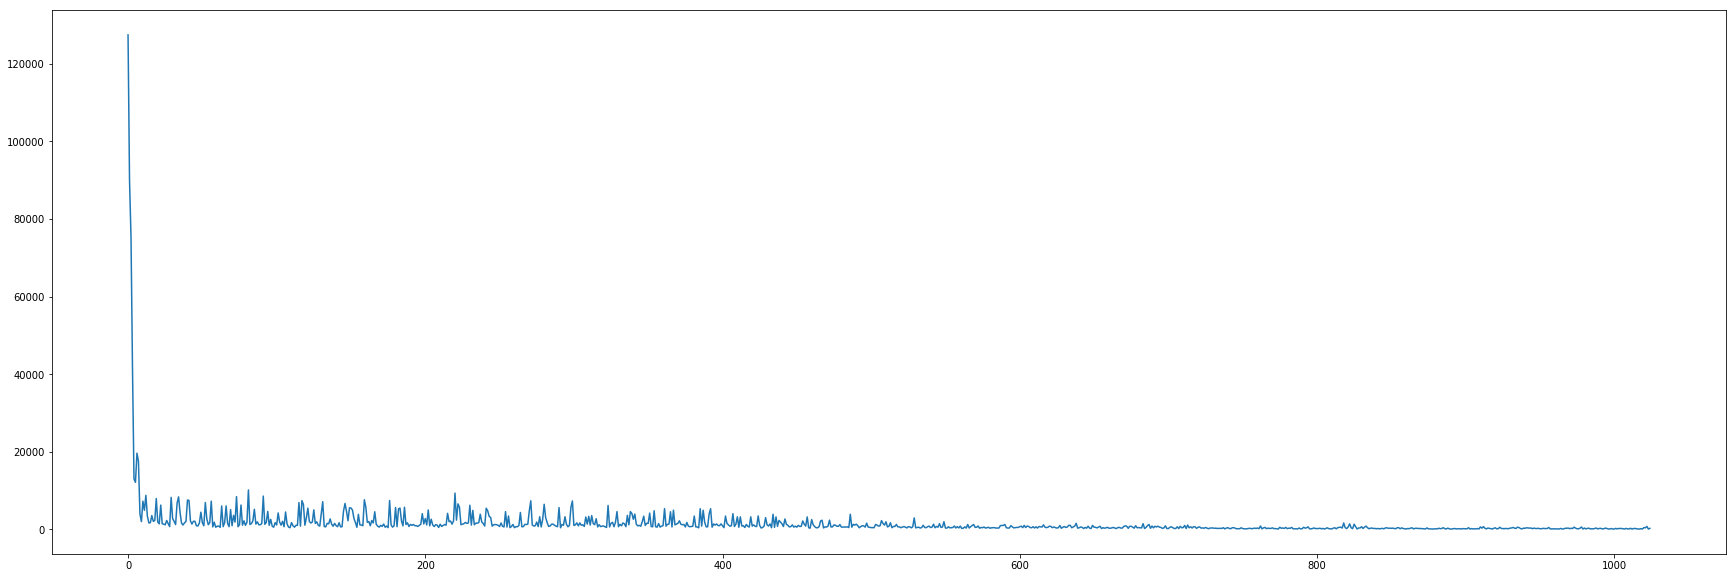

In [22]:
# 看看损失值变化情况
plt.figure(figsize=(30, 10))
plt.plot(train_loss)
plt.show()

In [23]:
# 保存为Fovea_Localization_Results.csv，但是好像存的会多一行，由于校园网连这个比较卡，
# 我也没怎么测试，就手动删掉然后提交结果，相信在后面的学习中自己能够进步
test_base_path = 'train_data/eyetrain/Train/PALM-Testing400-Images/'
test_images = os.listdir(test_base_path)
test_images = sorted(test_images)
test_base_path = 'train_data/eyetrain/Train/PALM-Testing400-Images/'
result = [['FileName', 'Fovea_X', 'Fovea_Y']]
for i in test_images:
    path = test_base_path + i
    img = Image.open(path)
    x, y = predict(net, np.array(img))
    # print([i, y, x])
    result.append([i, x, y])

result_s = np.array(result)
result_p = pd.DataFrame(result_s, columns=None, index=None)
result_p.to_csv('Fovea_Localization_Results.csv')
result_p.head(20)

/opt/conda/envs/python35-paddle120-env/lib/python3.7/site-packages/paddle/nn/layer/norm.py:641: UserWarning: When training, we now always track global mean and variance.
  "When training, we now always track global mean and variance.")


,0,1,2
0,FileName,Fovea_X,Fovea_Y
1,T0001.jpg,1073.5601957866124,1317.5856800079346
2,T0002.jpg,1056.3908848081317,1216.926894051688
3,T0003.jpg,1042.1011149542671,1175.8997992106847
4,T0004.jpg,1089.0787839889526,1348.024290357317
5,T0005.jpg,797.8850168500628,1074.5273571014404
6,T0006.jpg,1038.5423453194753,1167.1923776354108
7,T0007.jpg,1066.1392499378749,1266.719863619123
8,T0008.jpg,1070.4344714028493,1295.1920463017054
9,T0009.jpg,1050.031283242362,1192.2585067749023


1038.5423453194753 1167.1923776354108


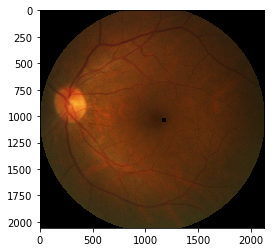

In [25]:
#
p = 190
img1 = Image.open('train_data/eyetrain/Train/PALM-Testing400-Images/T0006.jpg')
img1 = np.array(img1)
x, y = predict(net, img1)
print(x, y)
img1[int(x)-20:int(x) + 20, int(y)-20:int(y)+20, :] = 0
plt.imshow(img1)
plt.show()

In [ ]:
paddle.save(net.state_dict(), 'logs/10_16_1.pdparams')